In [1]:
import gc
import joblib
import six
import featuretools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import featuretools as ft

load the train data files

In [2]:
#os.chdir("C:\Users\Mr.VL\Desktop\Home Credit Default Risk")
df_train = pd.read_csv("application_train.csv")
df_train.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df_train.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int64  
 1    TARGET                        307511 non-null  int64  
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int64  
 7    AMT_INCOME_TOTAL              307511 non-null  float64
 8    AMT_CREDIT                    307511 non-null  float64
 9    AMT_ANNUITY                   307499 non-null  float64
 10   AMT_GOODS_PRICE               307233 non-null  float64
 11   NAME_TYPE_SUITE               306219 non-null  object 
 12   NAME_INCOME_TYPE            

Load other data files

In [4]:
"""bureau                = pd.read_csv("bureau.csv")
bureau_balance        = pd.read_csv("bureau_balance.csv")
credit_card_balance   = pd.read_csv("credit_card_balance.csv")
installments_payments = pd.read_csv("installments_payments.csv")
pos_cash_balance      = pd.read_csv("POS_CASH_balance.csv")
previous_application  = pd.read_csv("previous_application.csv")"""

'bureau                = pd.read_csv("bureau.csv")\nbureau_balance        = pd.read_csv("bureau_balance.csv")\ncredit_card_balance   = pd.read_csv("credit_card_balance.csv")\ninstallments_payments = pd.read_csv("installments_payments.csv")\npos_cash_balance      = pd.read_csv("POS_CASH_balance.csv")\nprevious_application  = pd.read_csv("previous_application.csv")'

Check dataset structres

In [5]:
"""print ("application_train     :",df_train.shape)
print ("bureau                :",bureau.shape)
print ("bureau_balance        :",bureau_balance.shape)
print ("credit_card_balance   :",credit_card_balance.shape)
print ("installments_payments :",installments_payments.shape)
print ("pos_cash_balance      :",pos_cash_balance.shape)
print ("previous_application  :",previous_application.shape)"""


'print ("application_train     :",df_train.shape)\nprint ("bureau                :",bureau.shape)\nprint ("bureau_balance        :",bureau_balance.shape)\nprint ("credit_card_balance   :",credit_card_balance.shape)\nprint ("installments_payments :",installments_payments.shape)\nprint ("pos_cash_balance      :",pos_cash_balance.shape)\nprint ("previous_application  :",previous_application.shape)'

In [6]:
"""# Helper function to optimize data types
def optimize_dataframe(df, name):
    print(f"\nOptimizing {name}...")
    start_mem = df.memory_usage().sum() / 1024**2 
    print(f"Memory usage of {name} before optimization: {start_mem:.2f} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    
    end_mem = df.memory_usage().sum() / 1024**2 
    print(f"Memory usage of {name} after optimization: {end_mem:.2f} MB")
    print(f"Reduced by {100 * (start_mem - end_mem) / start_mem:.1f}%")
    return df

# File paths
files = {
    "df_train": "application_train.csv",
    "bureau": "bureau.csv",
    "bureau_balance": "bureau_balance.csv",
    "credit_card_balance": "credit_card_balance.csv",
    "installments_payments": "installments_payments.csv",
    "pos_cash_balance": "POS_CASH_balance.csv",
    "previous_application": "previous_application.csv"
}

# Load, optimize, and store each dataframe

for name, path in files.items():
    df = pd.read_csv(path)
    df = optimize_dataframe(df, name)
    df.to_csv(f"{name}_optimized.csv", index=False)
    print(f"Saved{name} as {name}_optimized.parquet")

print("\nOptimization and storage complete.")"""


'# Helper function to optimize data types\ndef optimize_dataframe(df, name):\n    print(f"\nOptimizing {name}...")\n    start_mem = df.memory_usage().sum() / 1024**2 \n    print(f"Memory usage of {name} before optimization: {start_mem:.2f} MB")\n    \n    for col in df.columns:\n        col_type = df[col].dtype\n        \n        if col_type != object:\n            c_min = df[col].min()\n            c_max = df[col].max()\n            if str(col_type)[:3] == \'int\':\n                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:\n                    df[col] = df[col].astype(np.int8)\n                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:\n                    df[col] = df[col].astype(np.int16)\n                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:\n                    df[col] = df[col].astype(np.int32)\n                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:\n 

In [7]:
#data path after optimized

df_train_OD = pd.read_csv("df_train_optimized.csv")
bureau_OD =  pd.read_csv("bureau_optimized.csv")
bureau_balance_OD = pd.read_csv("bureau_balance_optimized.csv")
credit_card_balance_OD = pd.read_csv("credit_card_balance_optimized.csv")
installments_payments_OD =  pd.read_csv("installments_payments_optimized.csv")
pos_cash_balance_OD = pd.read_csv("pos_cash_balance_optimized.csv")
previous_application_OD=  pd.read_csv("previous_application_optimized.csv")

Exploratory Data Analysis

Checking data imbalance

There are 282686 loans repaid on time (TARGET=0) and 24825 loans defaulted (TARGET=1) in the dataset


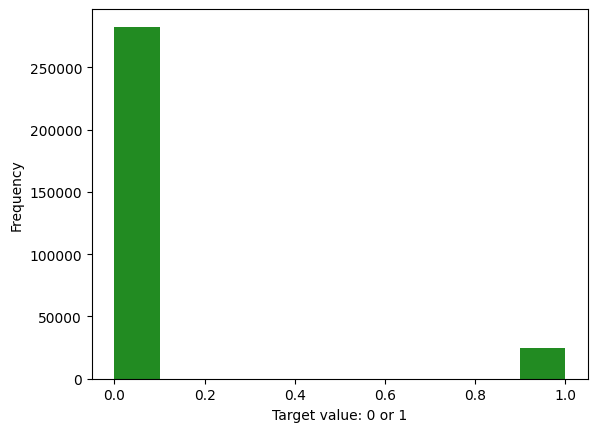

In [8]:

df_train_OD['TARGET'].astype(int).plot.hist(color='forestgreen').set_xlabel('Target value: 0 or 1');

count = df_train_OD['TARGET'].value_counts()
num_repaid = count[0]
num_default = count[1]

print("There are {} loans repaid on time (TARGET=0) and {} loans defaulted (TARGET=1) in the dataset".format(num_repaid, num_default))

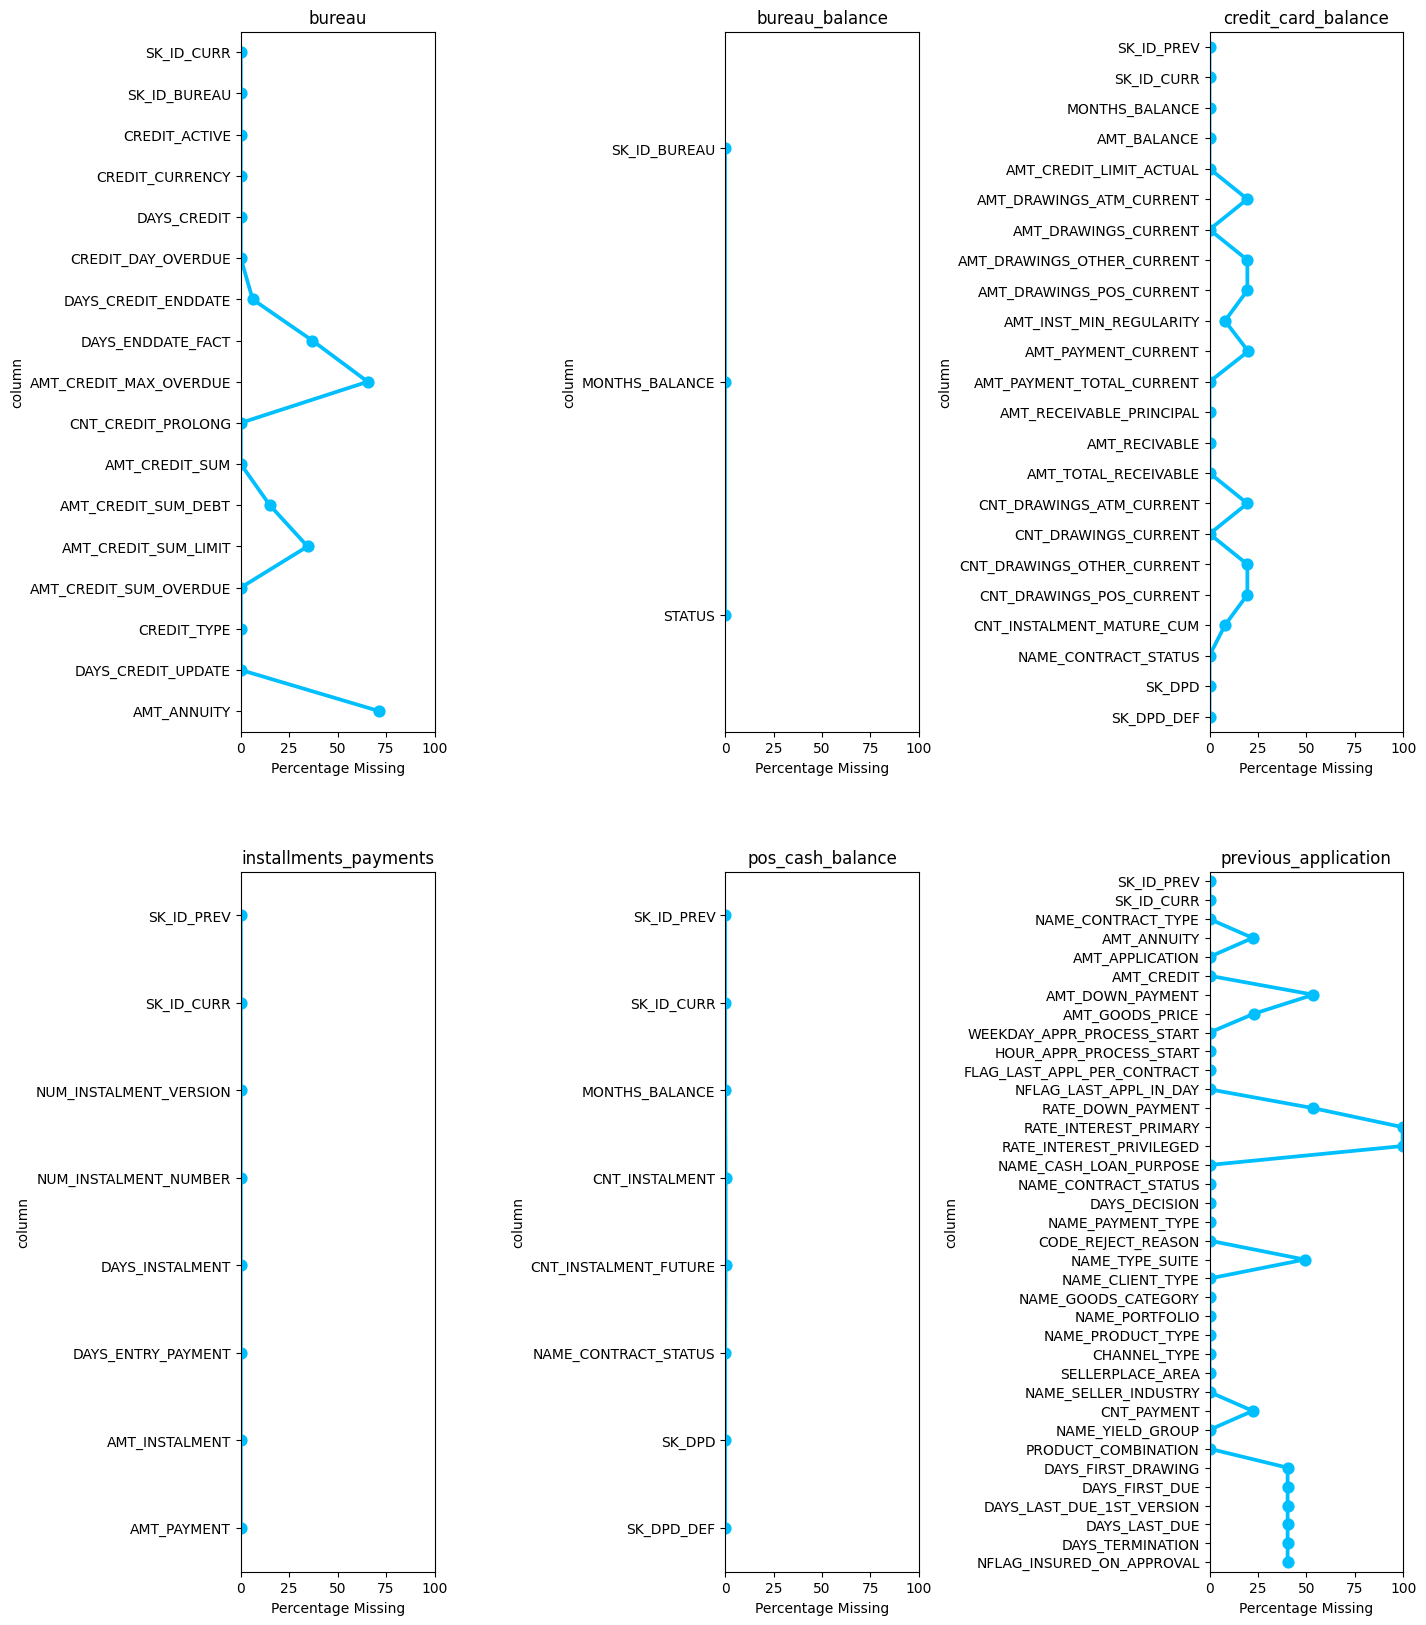

In [9]:
plt.figure(figsize=(15,20))

# Subplot 1: bureau
plt.subplot(231)
bureau_miss_data = pd.DataFrame(bureau_OD.isnull().sum() / bureau_OD.shape[0] * 100).reset_index()
bureau_miss_data.columns = ['column', 'missing_percentage']
sns.pointplot(x="missing_percentage", y="column", data=bureau_miss_data, color='deepskyblue')
plt.xlabel("Percentage Missing")
plt.xlim((0, 100))
plt.title("bureau")

# Subplot 2: bureau_balance
plt.subplot(232)
bureau_balance_miss_data = pd.DataFrame(bureau_balance_OD.isnull().sum() / bureau_balance_OD.shape[0] * 100).reset_index()
bureau_balance_miss_data.columns = ['column', 'missing_percentage']
sns.pointplot(x="missing_percentage", y="column", data=bureau_balance_miss_data, color='deepskyblue')
plt.xlabel("Percentage Missing")
plt.xlim((0, 100))
plt.title("bureau_balance")

# Subplot 3: credit_card_balance
plt.subplot(233)
credit_card_balance_miss_data = pd.DataFrame(credit_card_balance_OD.isnull().sum() / credit_card_balance_OD.shape[0] * 100).reset_index()
credit_card_balance_miss_data.columns = ['column', 'missing_percentage']
sns.pointplot(x="missing_percentage", y="column", data=credit_card_balance_miss_data, color='deepskyblue')
plt.xlabel("Percentage Missing")
plt.xlim((0, 100))
plt.title("credit_card_balance")

# Subplot 4: installments_payments
plt.subplot(234)
installments_payments_miss_data = pd.DataFrame(installments_payments_OD.isnull().sum() / installments_payments_OD.shape[0] * 100).reset_index()
installments_payments_miss_data.columns = ['column', 'missing_percentage']
sns.pointplot(x="missing_percentage", y="column", data=installments_payments_miss_data, color='deepskyblue')
plt.xlabel("Percentage Missing")
plt.xlim((0, 100))
plt.title("installments_payments")

# Subplot 5: pos_cash_balance with 
plt.subplot(235)
pos_cash_balance_miss_data = pd.DataFrame(pos_cash_balance_OD.isnull().sum() / pos_cash_balance_OD.shape[0] * 100).reset_index()
pos_cash_balance_miss_data.columns = ['column', 'missing_percentage']
sns.pointplot(x="missing_percentage", y="column", data=pos_cash_balance_miss_data, color='deepskyblue')
plt.xlabel("Percentage Missing")
plt.xlim((0, 100))
plt.title("pos_cash_balance")

# Subplot 6: previous_application
plt.subplot(236)
previous_application_miss_data = pd.DataFrame(previous_application_OD.isnull().sum() / previous_application_OD.shape[0] * 100).reset_index()
previous_application_miss_data.columns = ['column', 'missing_percentage']
sns.pointplot(x="missing_percentage", y="column", data=previous_application_miss_data, color='deepskyblue')
plt.xlabel("Percentage Missing")
plt.xlim((0, 100))
plt.title("previous_application")

# Adjust spacing between plots
plt.subplots_adjust(wspace=1.5)

plt.show()


In [10]:
def plot_bar_gen(feature, df = None, orientation_horizontal = True):
    
    if df is None:
        df = df_train_OD
    else:
        df = df
    
    temp = df[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = df[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    sns.set_color_codes("colorblind")
    
    if orientation_horizontal == True:
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        s1 = sns.barplot(y = feature, x="Number of contracts",data=df1)
        plt.subplot(122)
        s2 = sns.barplot(y = feature, x='TARGET', data=cat_perc)
        plt.xlabel('Fraction of loans defaulted', fontsize=12)
        plt.ylabel(feature, fontsize=12)
        
    else:
        plt.figure(figsize=(10,18))
        plt.subplot(211)
        s1 = sns.barplot(x = feature, y="Number of contracts",data=df1)
        s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
        plt.subplot(212)
        s2 = sns.barplot(x = feature, y='TARGET', data=cat_perc)
        s2.set_xticklabels(s2.get_xticklabels(),rotation=90)
        plt.ylabel('Fraction of loans defaulted', fontsize=12)
        plt.xlabel(feature, fontsize=12)
    
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.subplots_adjust(wspace = 0.6)
    plt.show();

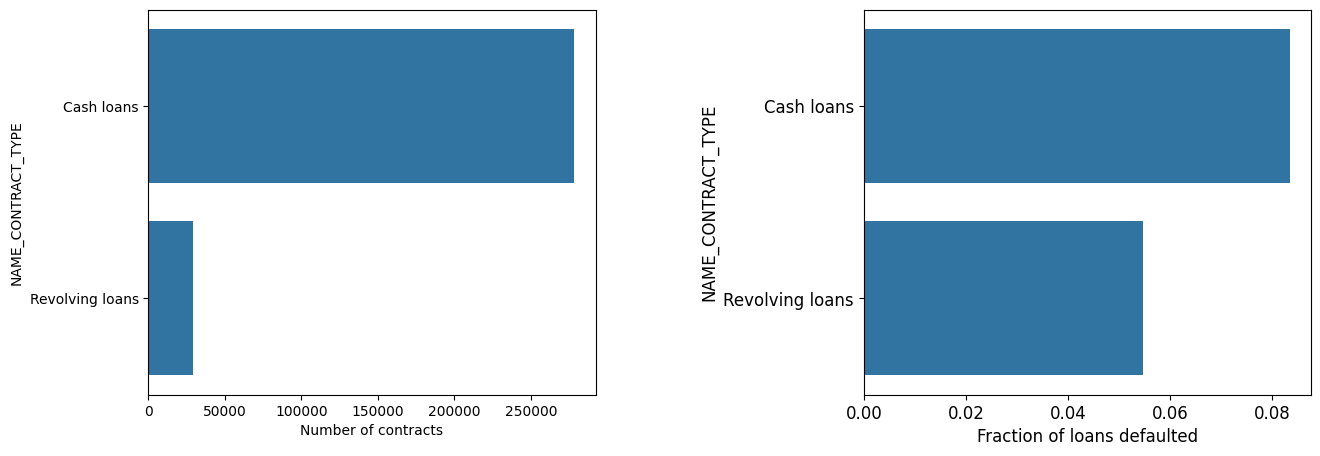

In [11]:
plot_bar_gen('NAME_CONTRACT_TYPE')

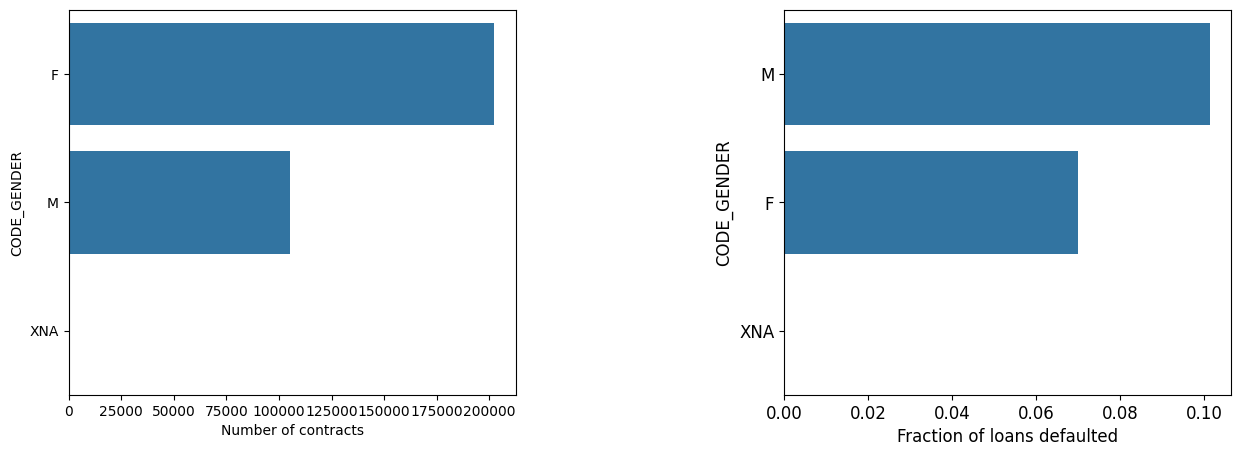

In [12]:
plot_bar_gen(('CODE_GENDER'))

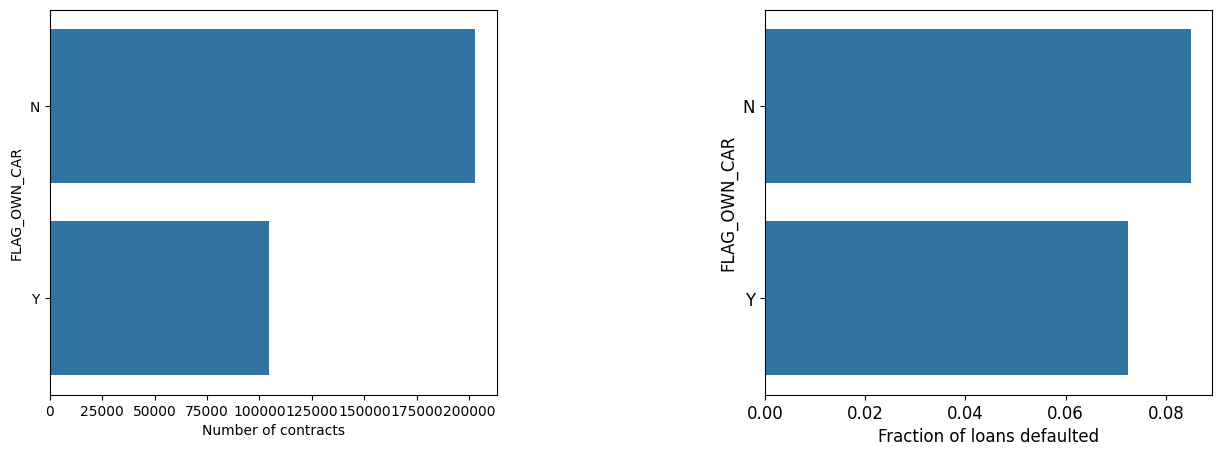

In [13]:
plot_bar_gen('FLAG_OWN_CAR')

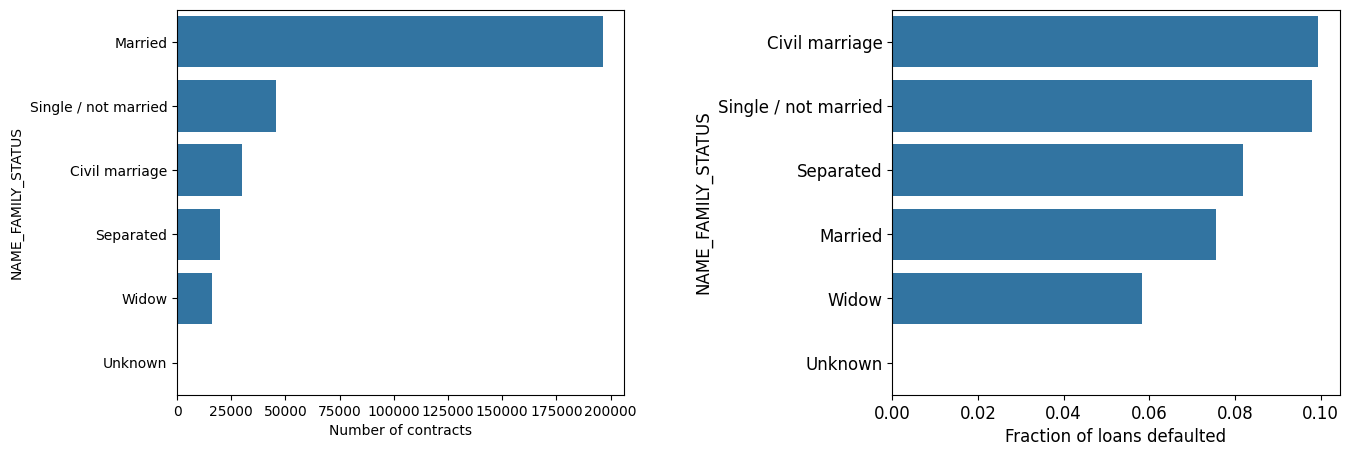

In [14]:
plot_bar_gen('NAME_FAMILY_STATUS')

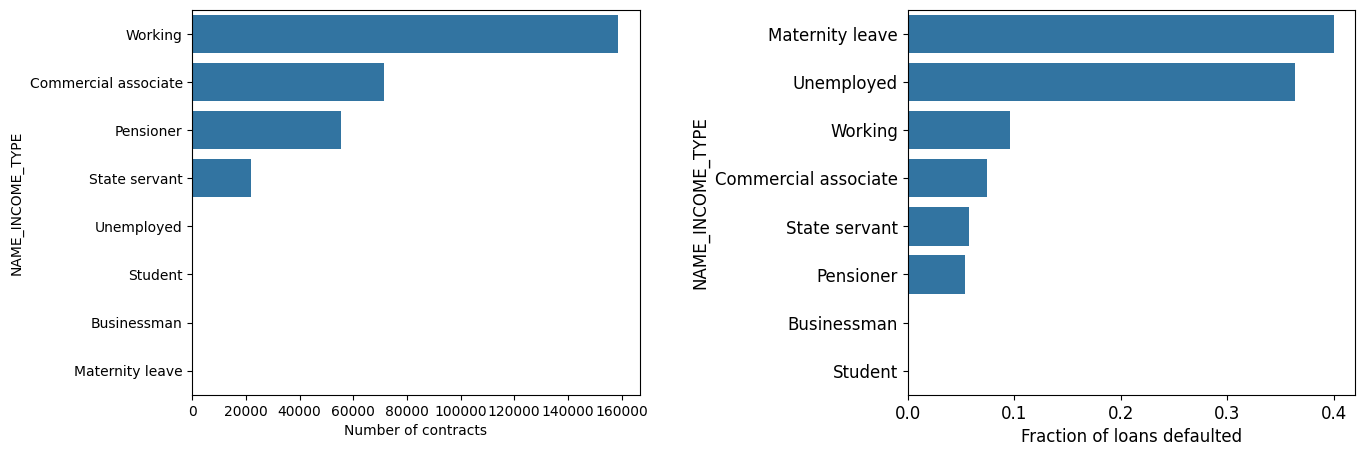

In [15]:
plot_bar_gen('NAME_INCOME_TYPE')


C:\Users\Mr.VL\AppData\Local\Temp\ipykernel_3132\3865105063.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
C:\Users\Mr.VL\AppData\Local\Temp\ipykernel_3132\3865105063.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s2.set_xticklabels(s2.get_xticklabels(),rotation=90)


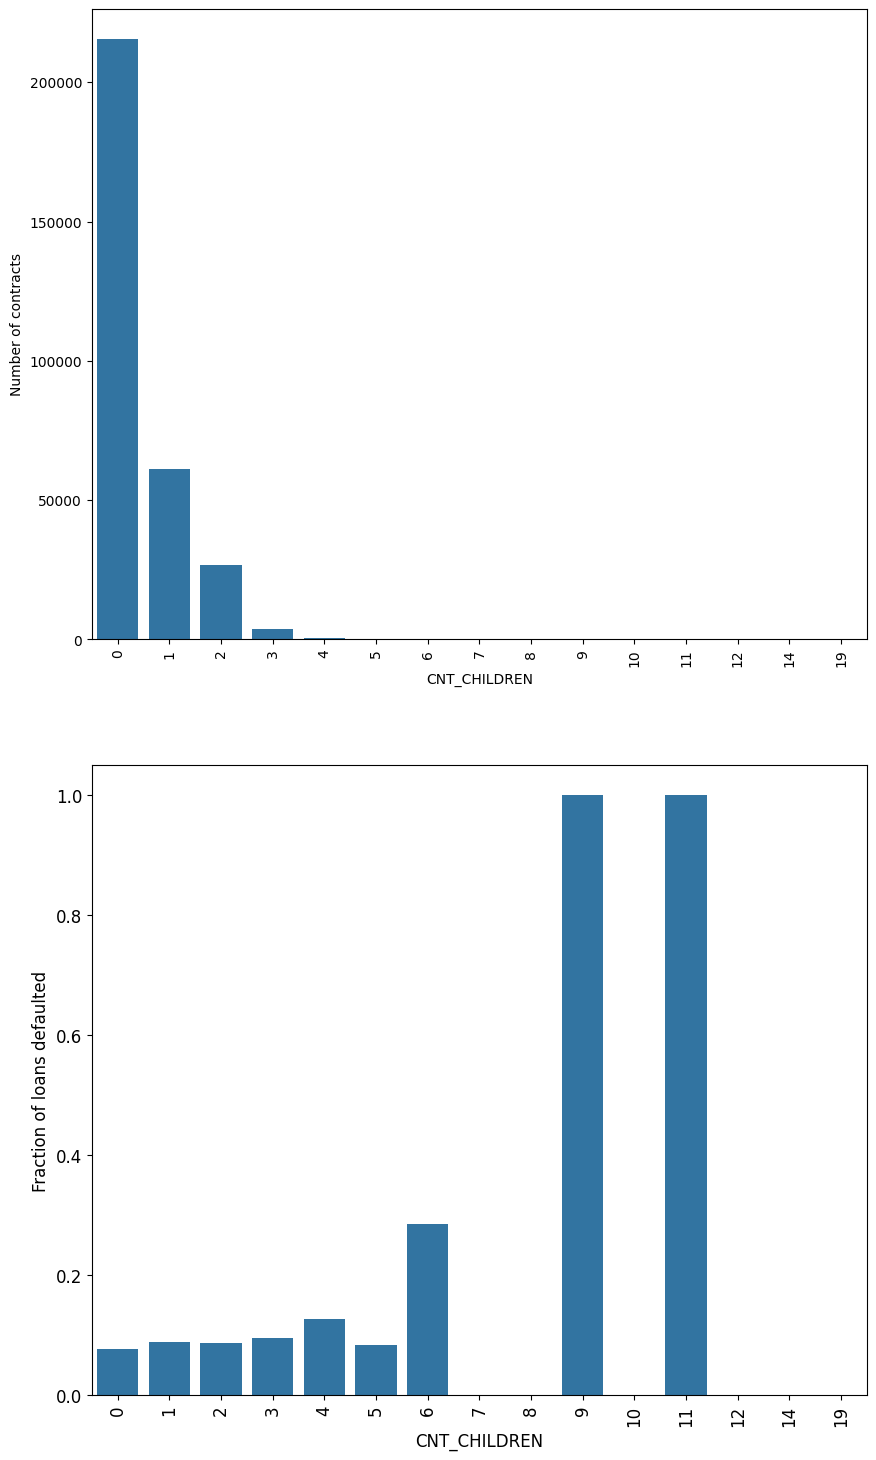

In [16]:
plot_bar_gen('CNT_CHILDREN' , None,False)

C:\Users\Mr.VL\AppData\Local\Temp\ipykernel_3132\3865105063.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
C:\Users\Mr.VL\AppData\Local\Temp\ipykernel_3132\3865105063.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s2.set_xticklabels(s2.get_xticklabels(),rotation=90)


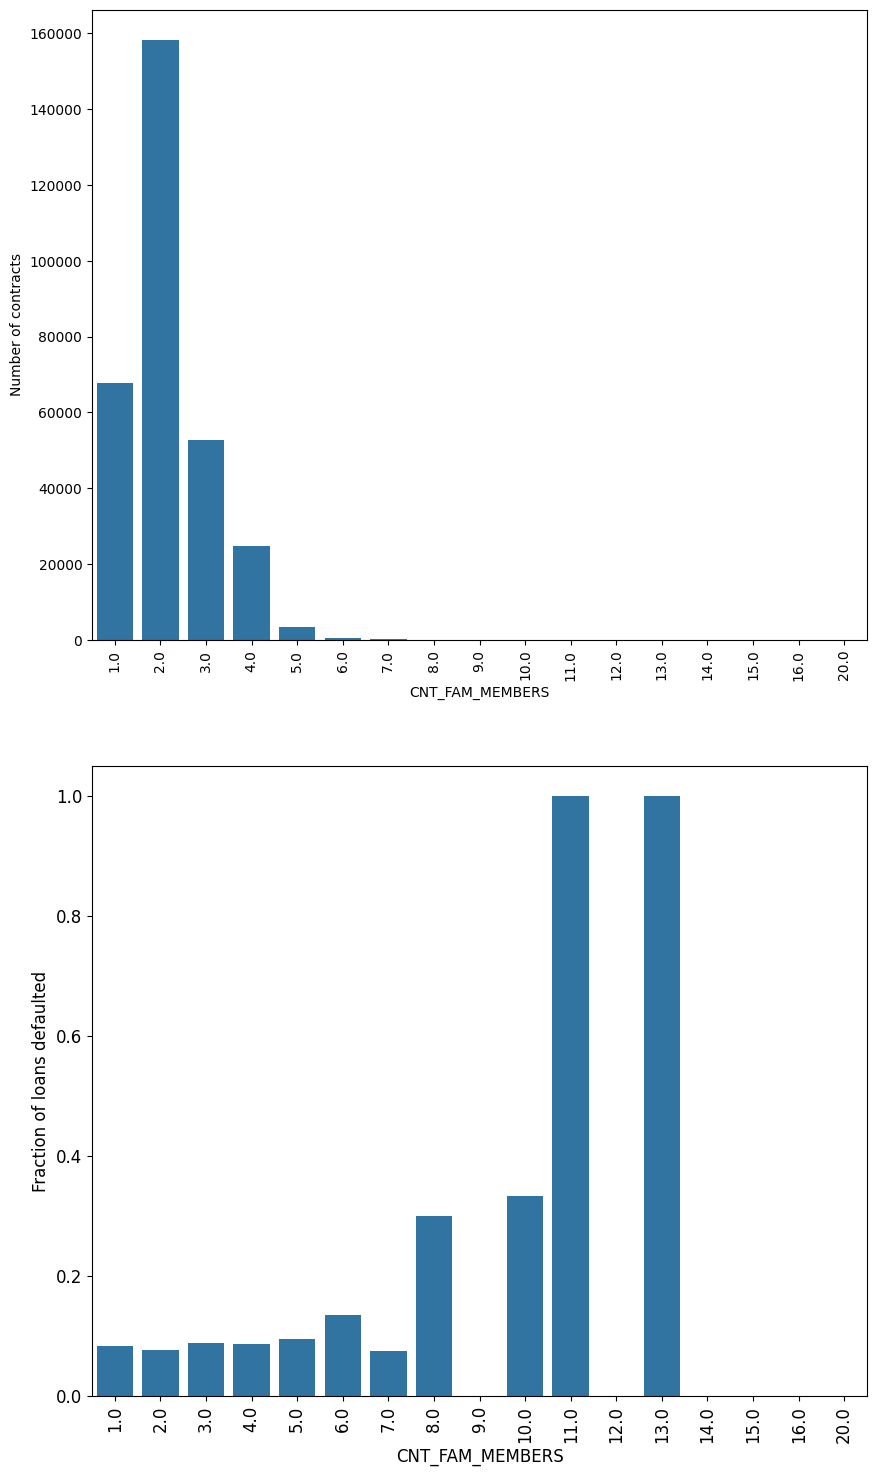

In [17]:
plot_bar_gen('CNT_FAM_MEMBERS',None,False)

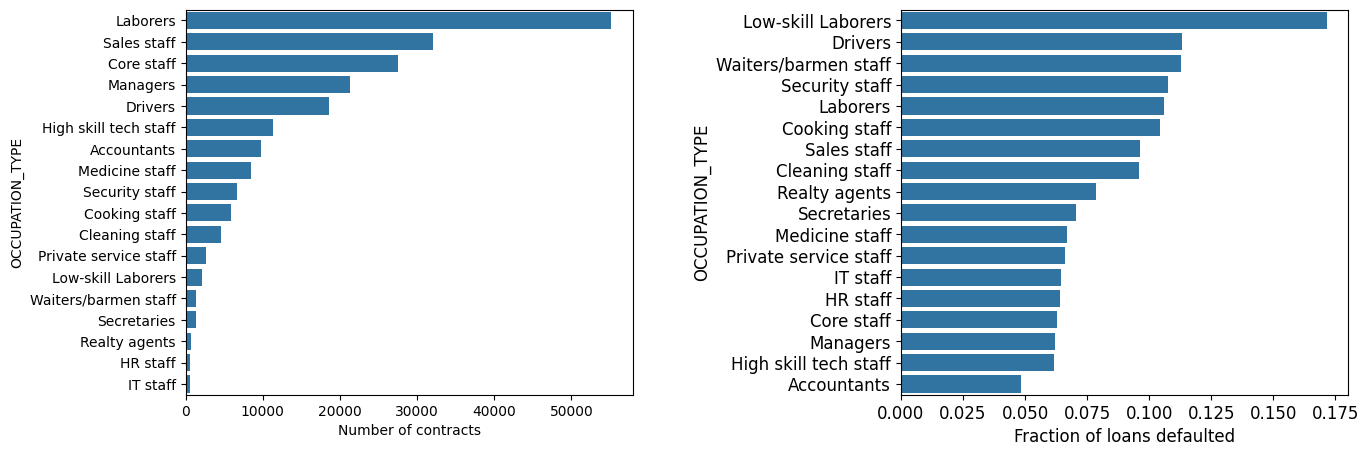

In [18]:
plot_bar_gen('OCCUPATION_TYPE')

C:\Users\Mr.VL\AppData\Local\Temp\ipykernel_3132\3865105063.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
C:\Users\Mr.VL\AppData\Local\Temp\ipykernel_3132\3865105063.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s2.set_xticklabels(s2.get_xticklabels(),rotation=90)


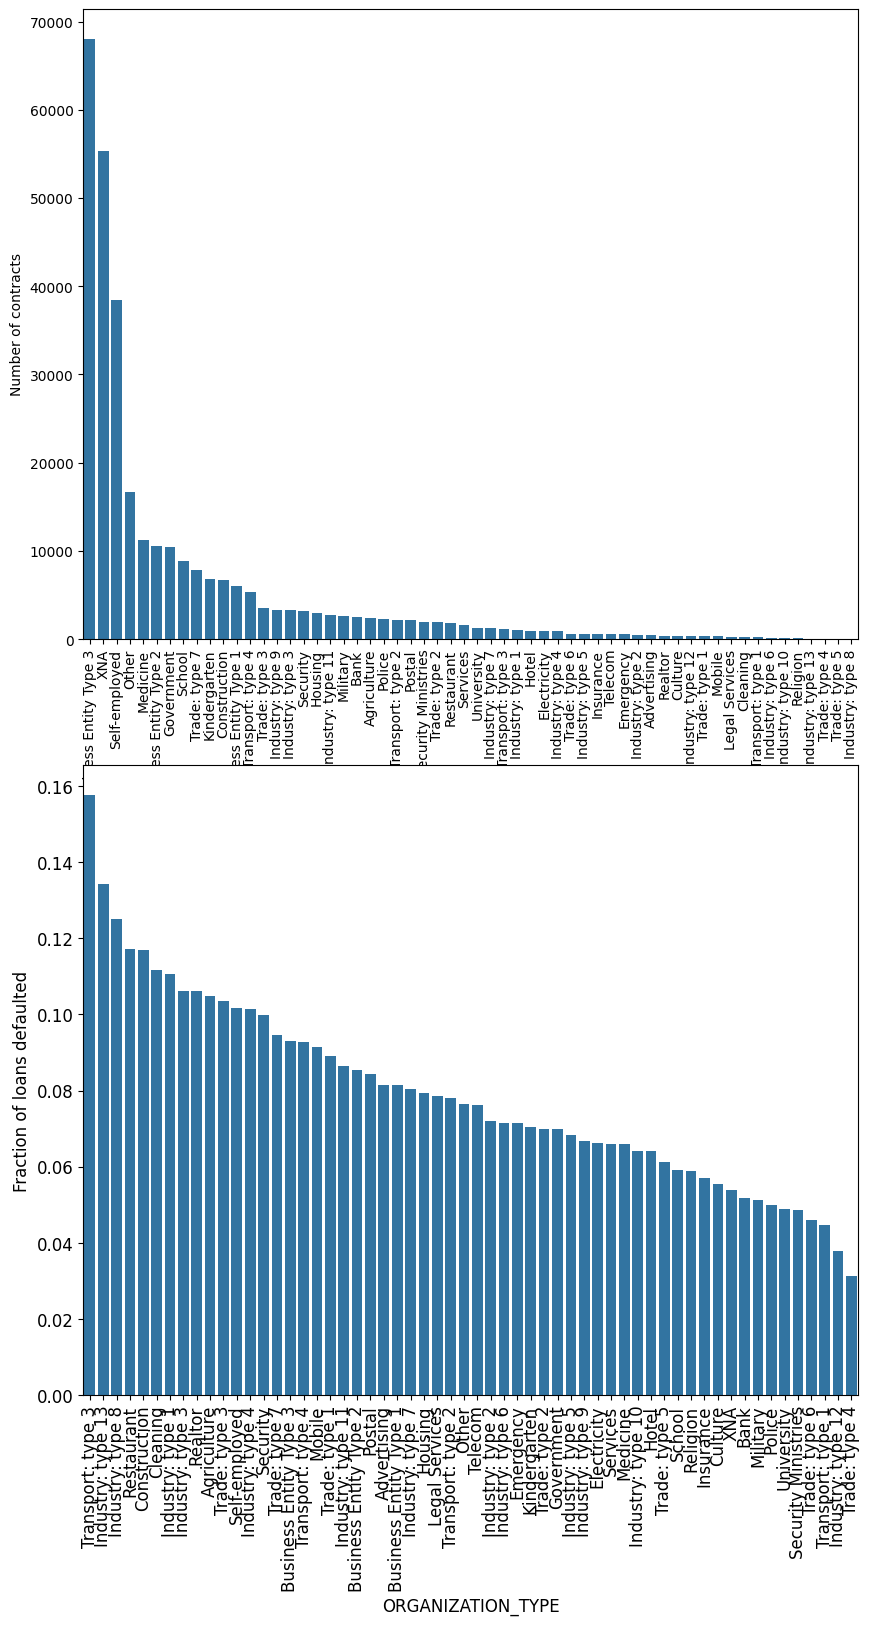

In [19]:
plot_bar_gen('ORGANIZATION_TYPE',None,False)

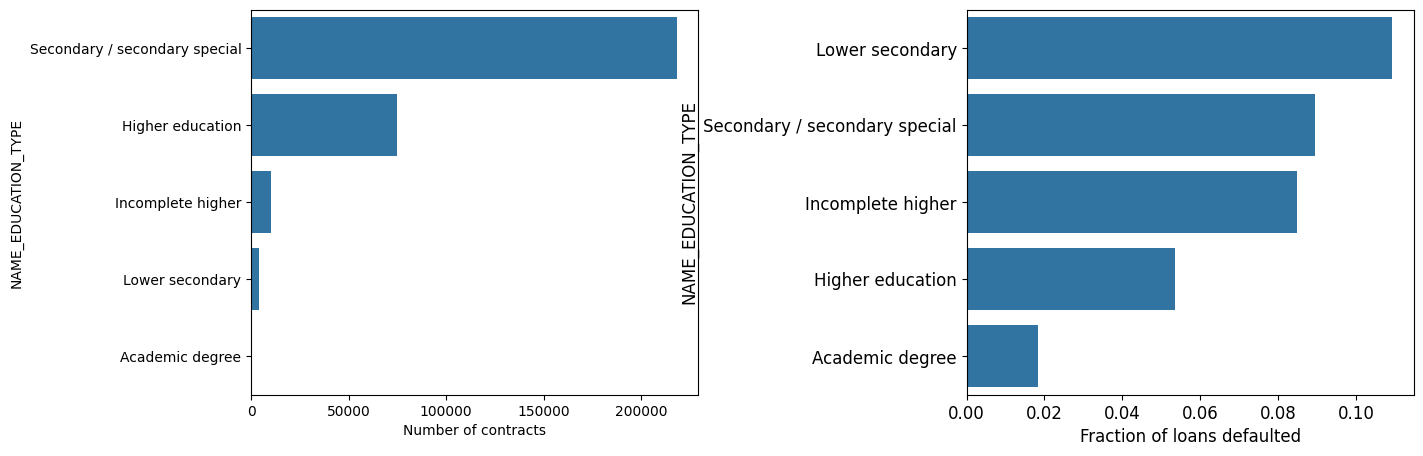

In [20]:
plot_bar_gen('NAME_EDUCATION_TYPE')

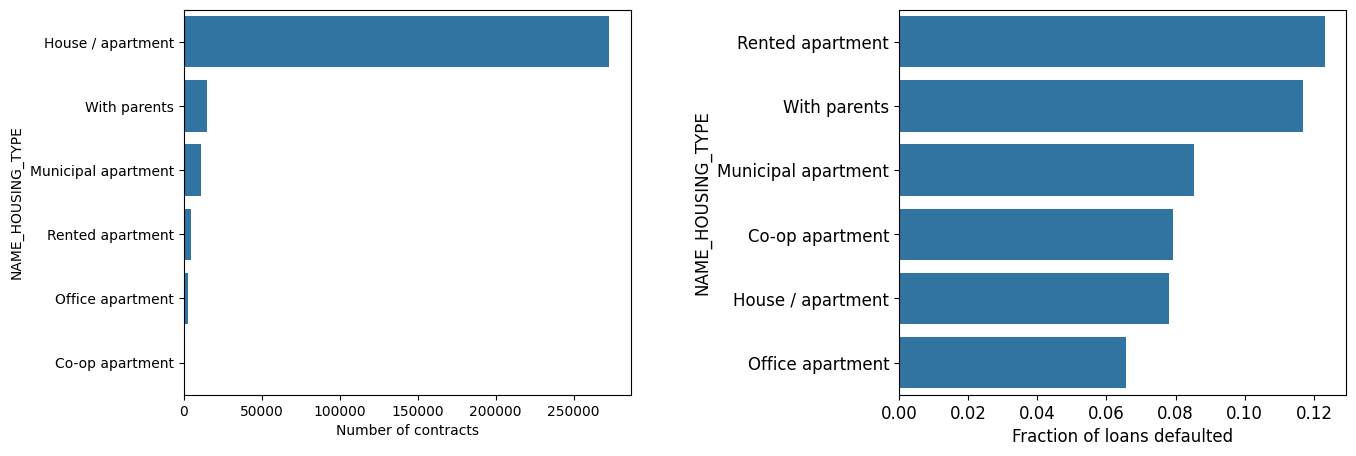

In [21]:
plot_bar_gen('NAME_HOUSING_TYPE')

C:\Users\Mr.VL\AppData\Local\Temp\ipykernel_3132\3865105063.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
C:\Users\Mr.VL\AppData\Local\Temp\ipykernel_3132\3865105063.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s2.set_xticklabels(s2.get_xticklabels(),rotation=90)


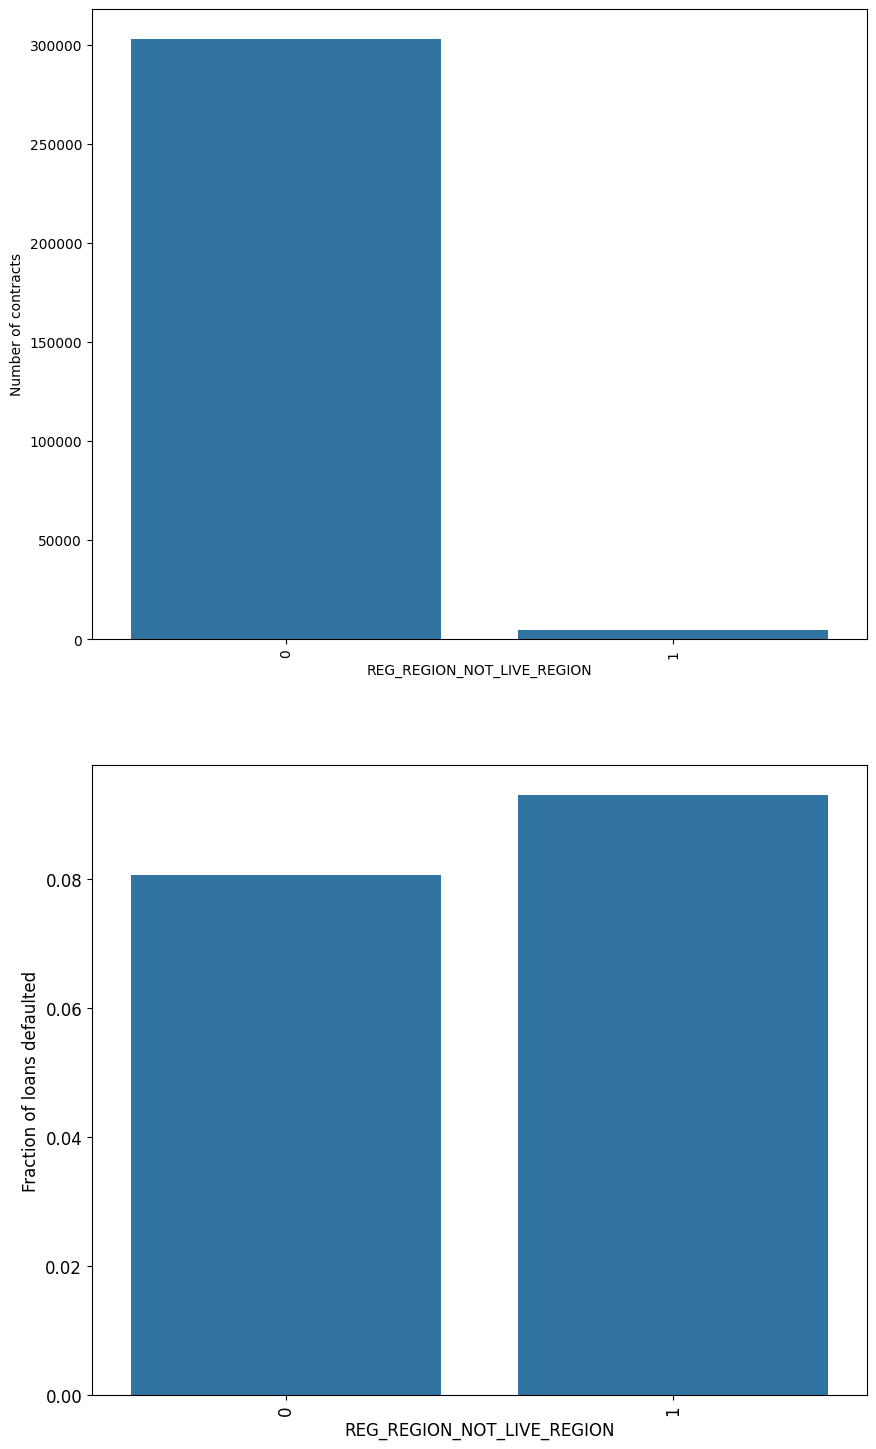

In [22]:
plot_bar_gen('REG_REGION_NOT_LIVE_REGION',None,False)


C:\Users\Mr.VL\AppData\Local\Temp\ipykernel_3132\3865105063.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
C:\Users\Mr.VL\AppData\Local\Temp\ipykernel_3132\3865105063.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s2.set_xticklabels(s2.get_xticklabels(),rotation=90)


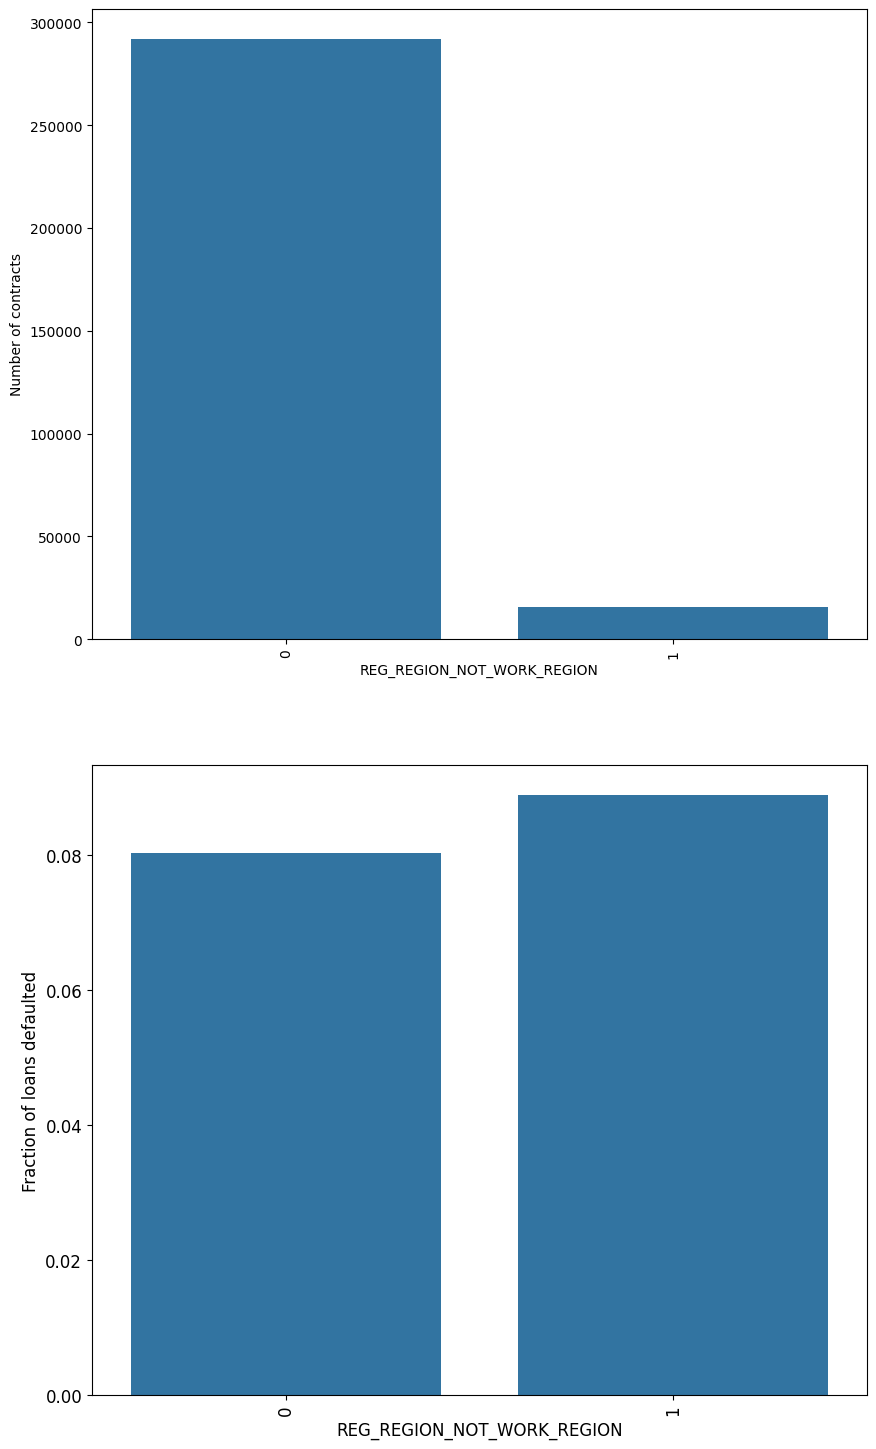

In [23]:
plot_bar_gen('REG_REGION_NOT_WORK_REGION',None,False)

C:\Users\Mr.VL\AppData\Local\Temp\ipykernel_3132\3865105063.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
C:\Users\Mr.VL\AppData\Local\Temp\ipykernel_3132\3865105063.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s2.set_xticklabels(s2.get_xticklabels(),rotation=90)


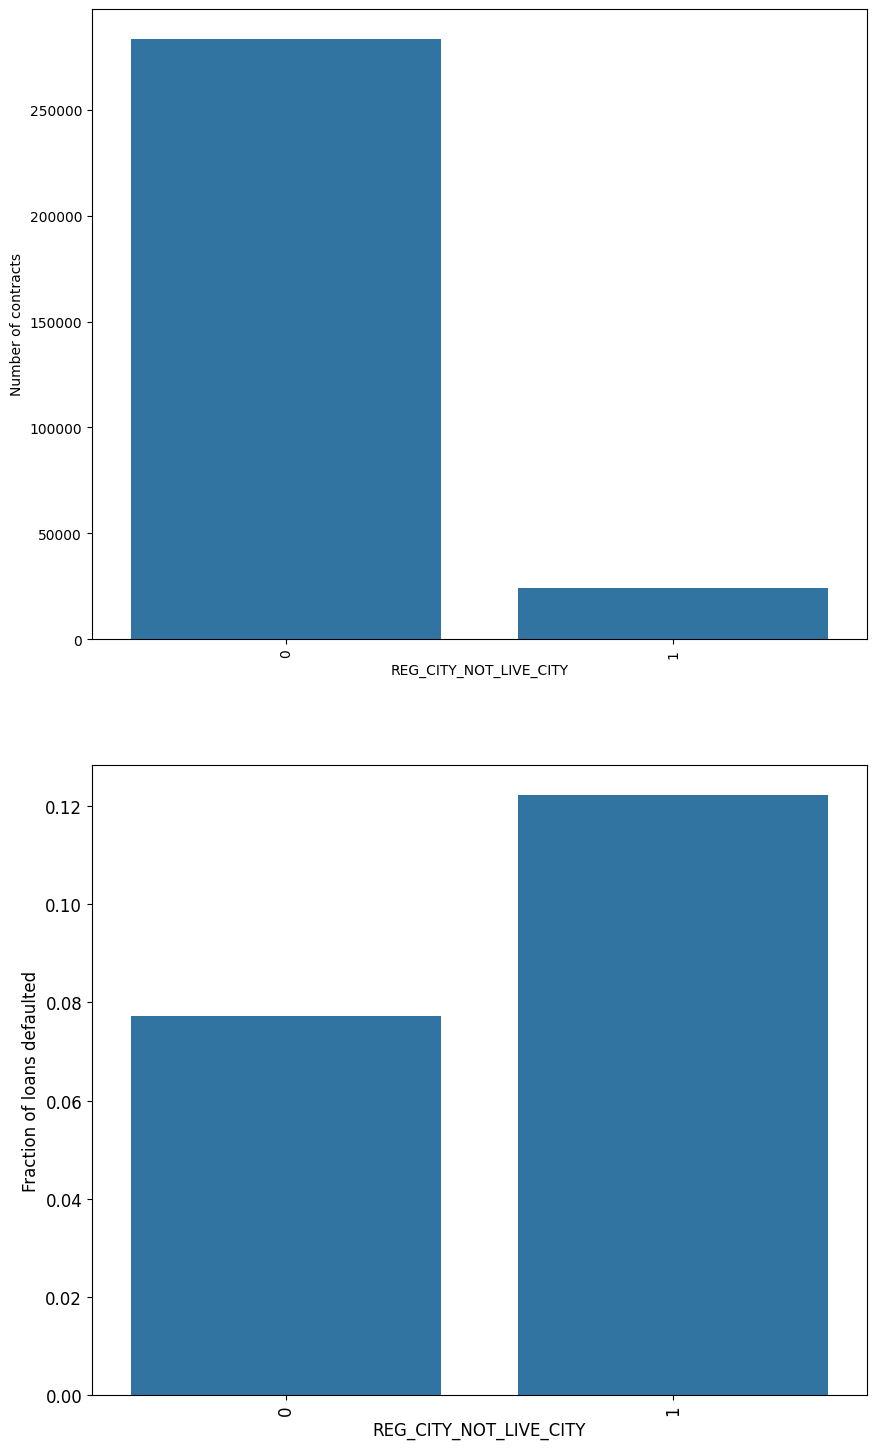

In [24]:
plot_bar_gen('REG_CITY_NOT_LIVE_CITY',None,False)

C:\Users\Mr.VL\AppData\Local\Temp\ipykernel_3132\3865105063.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
C:\Users\Mr.VL\AppData\Local\Temp\ipykernel_3132\3865105063.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s2.set_xticklabels(s2.get_xticklabels(),rotation=90)


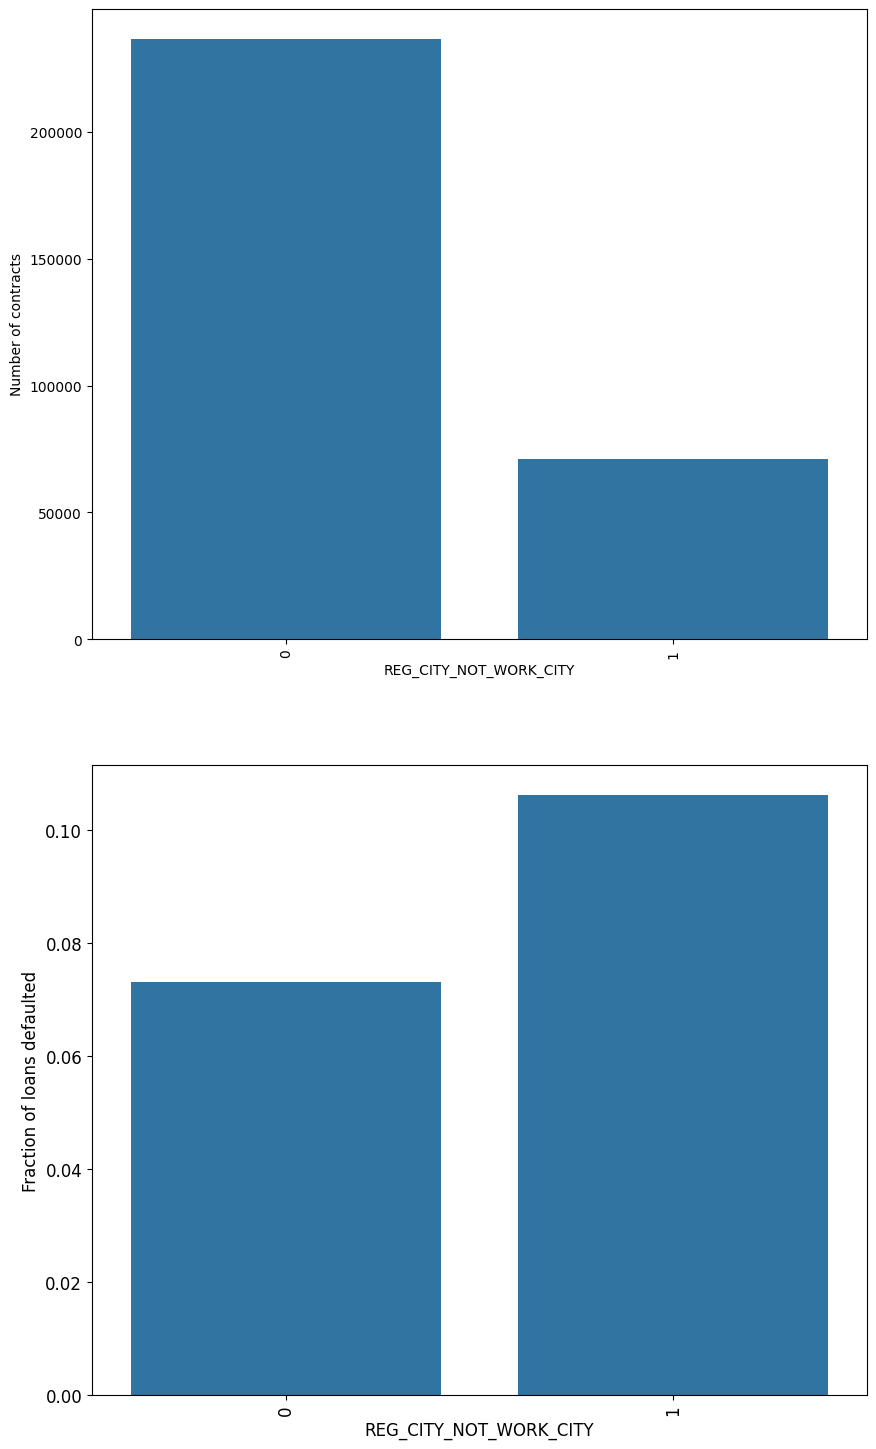

In [25]:
plot_bar_gen('REG_CITY_NOT_WORK_CITY',None,False)

In [26]:
# Plot distribution of one feature with or without paid/default shown separately

def plot_distribution_gen(feature,df=None,separate_target=False):
    if df is None:
        df = df_train_OD
    else:
        df = df
        
    if separate_target == False:
        plt.figure(figsize=(10,6))
        plt.title("Distribution of %s" % feature)
        sns.distplot(df[feature].dropna(),color='red', kde=True,bins=100)
    else:
        t1 = df.loc[df['TARGET'] != 0]
        t0 = df.loc[df['TARGET'] == 0]
        
        plt.figure(figsize=(10,6))
        plt.title("Distribution of %s" % feature)
        sns.set_style('whitegrid')
#         sns.kdeplot(t1[feature], bw=0.5,label="Loan defaulted (TARGET=1)")
#         sns.kdeplot(t0[feature], bw=0.5,label="Loan repaid (TARGET = 0)")
        
        sns.kdeplot(df.loc[df['TARGET'] == 0, feature], label = 'target == 0')
        sns.kdeplot(df.loc[df['TARGET'] == 1, feature], label = 'target == 1')
    
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        plt.legend(loc="best", labels=['Loan repaid (TARGET=0)', 'Loan defaulted (TARGET=1)'])
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

In [27]:
def get_thresh(feature):
    """ Outliers are usually > 3 standard deviations away from the mean. """
    ave=np.mean(df_train_OD[feature])
    sdev=np.std(df_train_OD[feature])
    threshold=round(ave+(3*sdev),2)
    print('Threshold for',feature,':',threshold)
    return threshold

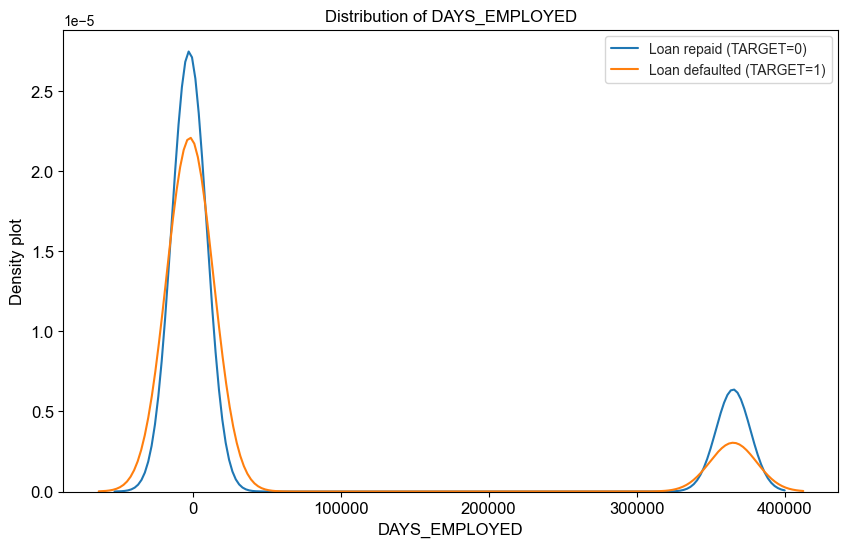

In [28]:
plot_distribution_gen('DAYS_EMPLOYED',None,True)

C:\Users\Mr.VL\AppData\Local\Temp\ipykernel_3132\3988394504.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature].dropna(),color='red', kde=True,bins=100)


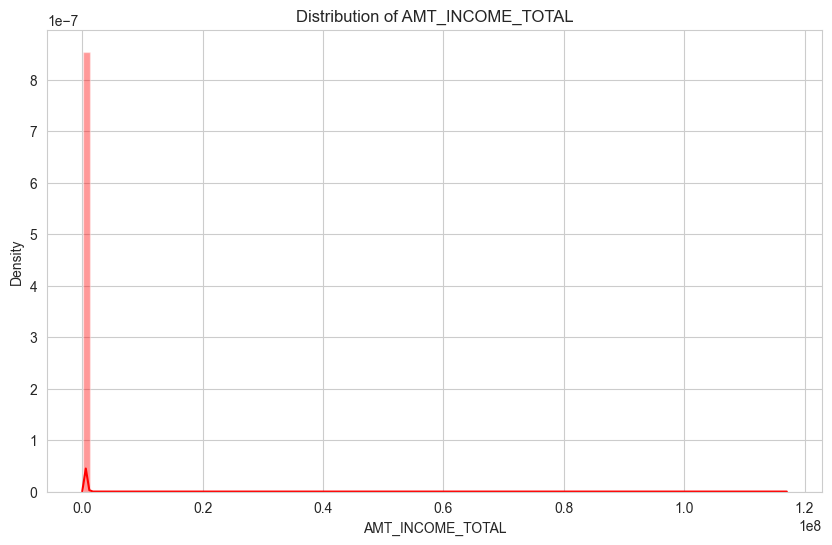

In [29]:
plot_distribution_gen('AMT_INCOME_TOTAL')

In [30]:
thresh_income = get_thresh('AMT_INCOME_TOTAL')
thresh_employment = get_thresh('DAYS_EMPLOYED')

anomalous_employment = df_train_OD[df_train_OD['DAYS_EMPLOYED'] > 0]
normal_employment = df_train_OD[df_train_OD['DAYS_EMPLOYED'] < 0]

print('The non-anomalies default on %0.2f%% of loans' % (100 * normal_employment['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anomalous_employment['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anomalous_employment))

Threshold for AMT_INCOME_TOTAL : 880166.2
Threshold for DAYS_EMPLOYED : 487641.66
The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


In [31]:
df_train_OD['DAYS_EMPLOYED'].mask(df_train_OD['DAYS_EMPLOYED'] > 0, inplace=True)
df_train_OD['AMT_INCOME_TOTAL'].mask(df_train_OD['AMT_INCOME_TOTAL'] > thresh_income, inplace=True)

C:\Users\Mr.VL\AppData\Local\Temp\ipykernel_3132\796134996.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train_OD['DAYS_EMPLOYED'].mask(df_train_OD['DAYS_EMPLOYED'] > 0, inplace=True)
C:\Users\Mr.VL\AppData\Local\Temp\ipykernel_3132\796134996.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alway

In [32]:
def create_day_to_year(df,ls_cols,newcol):
    df[newcol] = round(np.abs(df[ls_cols[0]]/365))
    df.drop(columns=ls_cols,inplace=True);
    return df

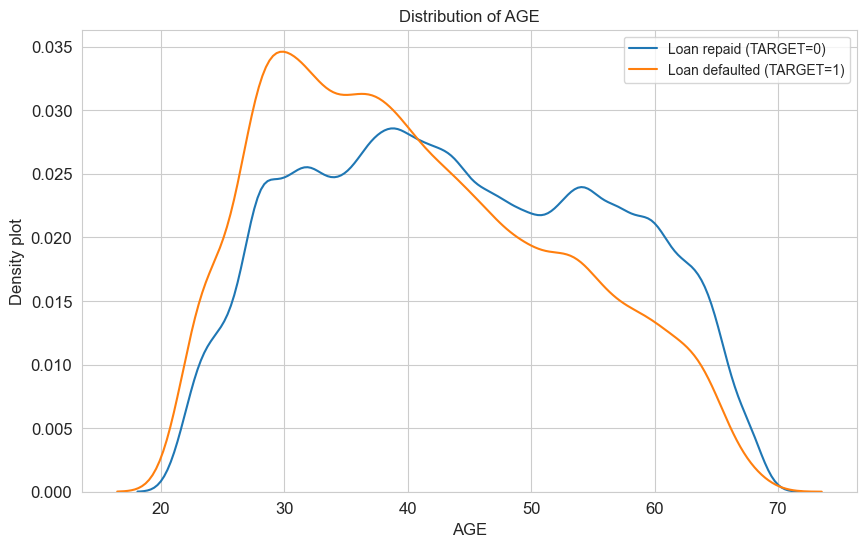

In [33]:
create_day_to_year(df_train_OD,['DAYS_BIRTH'],'AGE');
plot_distribution_gen('AGE',None,True)

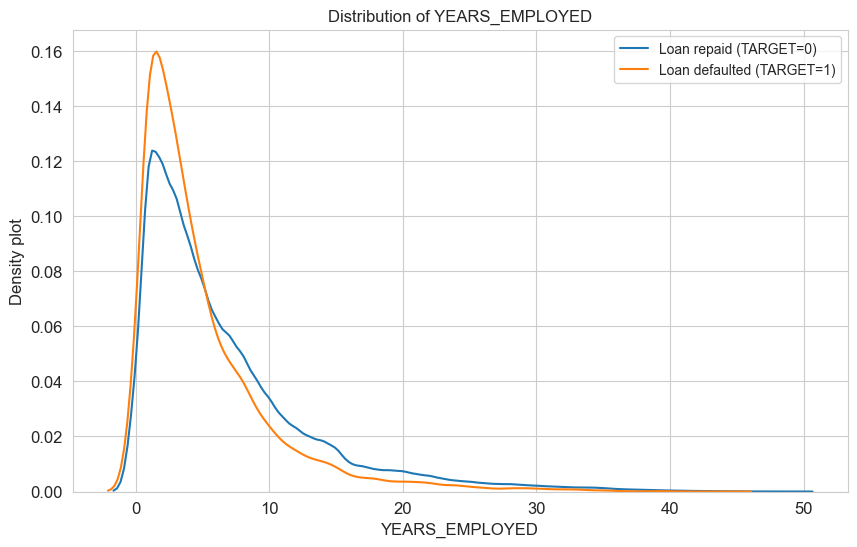

In [34]:
create_day_to_year(df_train_OD,['DAYS_EMPLOYED'],'YEARS_EMPLOYED');
plot_distribution_gen('YEARS_EMPLOYED',None,True)

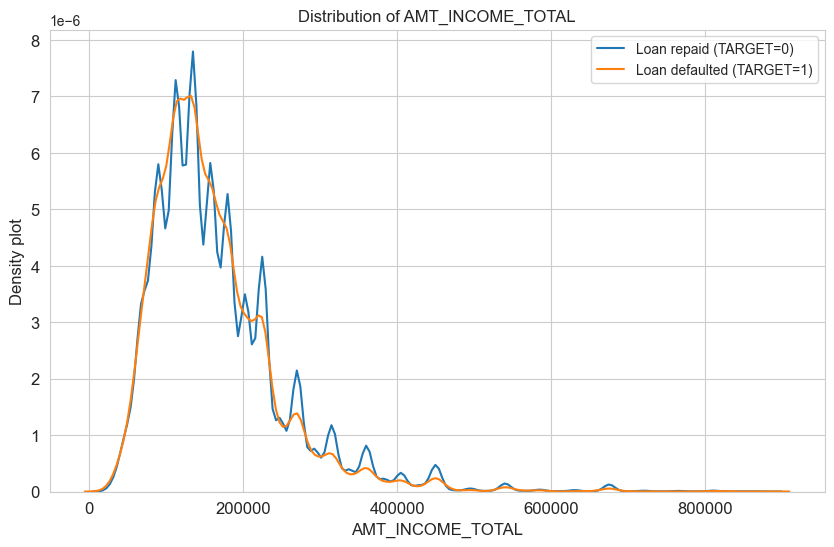

In [35]:
plot_distribution_gen('AMT_INCOME_TOTAL',None,True)

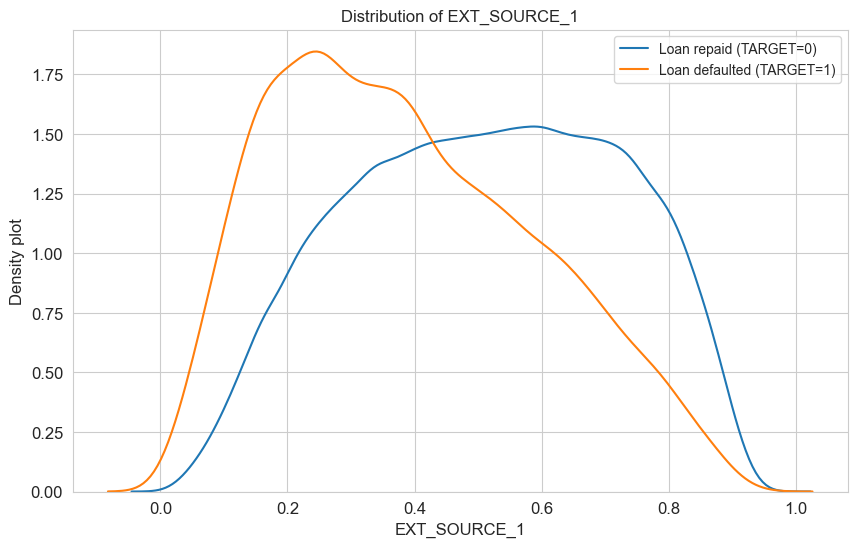

In [36]:
plot_distribution_gen('EXT_SOURCE_1',None,True)

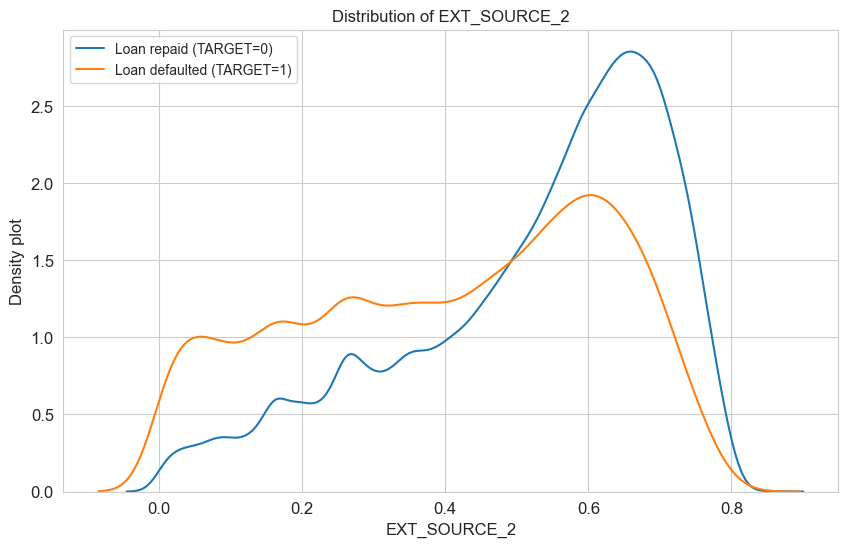

In [37]:
plot_distribution_gen('EXT_SOURCE_2',None,True)

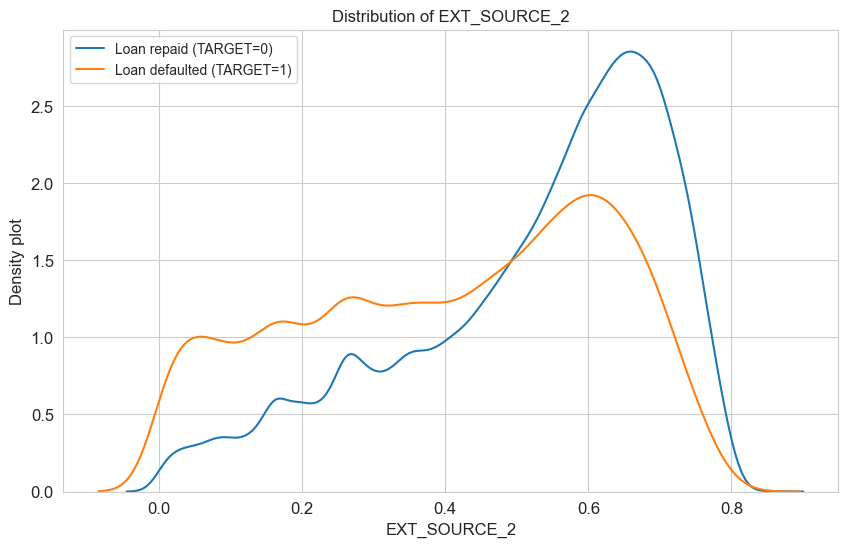

In [38]:
plot_distribution_gen('EXT_SOURCE_2',None,True)

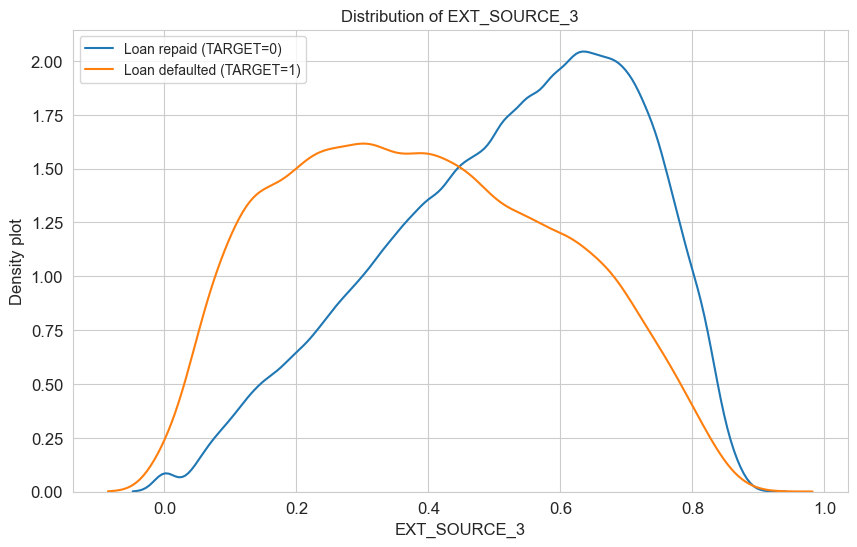

In [39]:
plot_distribution_gen('EXT_SOURCE_3', None,True)

In [40]:
create_day_to_year(df_train_OD,['DAYS_REGISTRATION'],'YEARS_REGISTRATION');

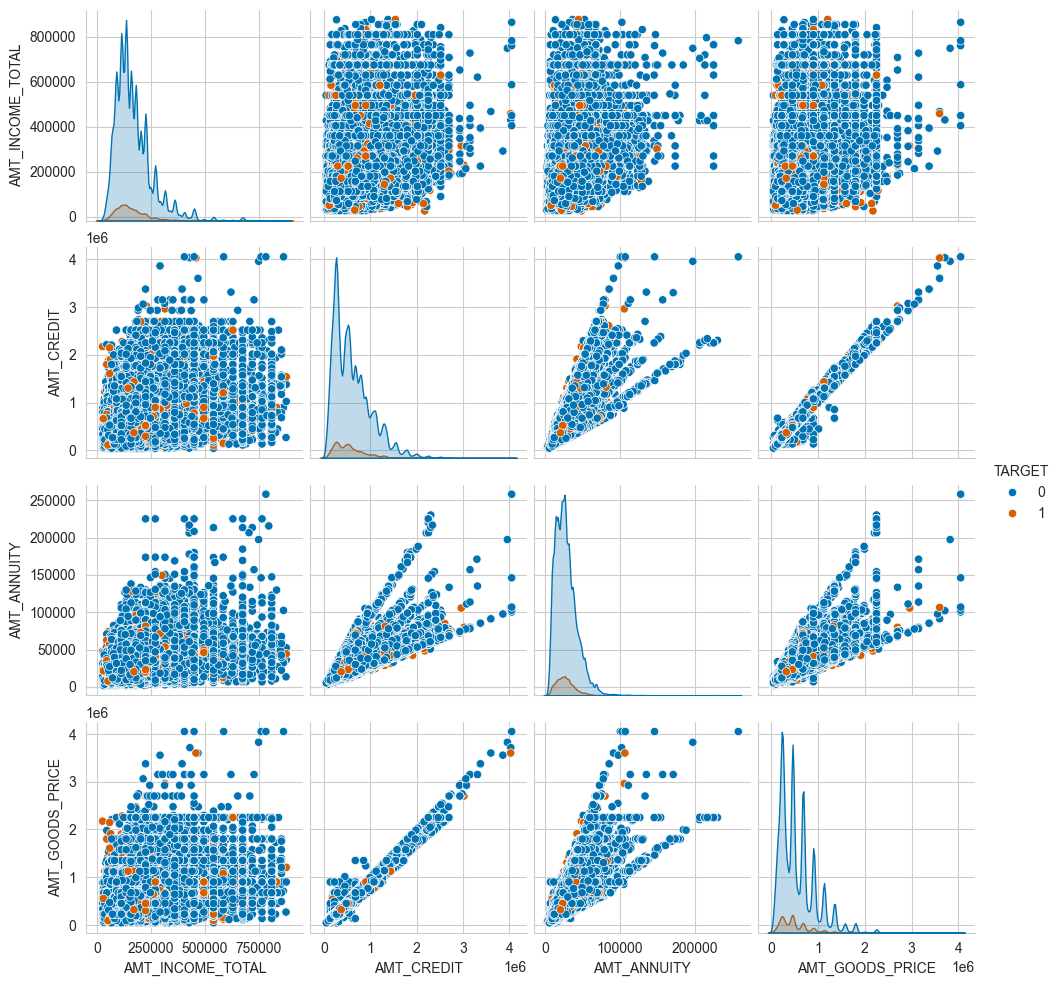

In [41]:
amt = df_train_OD[[ 'AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY', 'AMT_GOODS_PRICE',"TARGET"]]
amt = amt[(amt["AMT_GOODS_PRICE"].notnull()) & (amt["AMT_ANNUITY"].notnull())]
g = sns.pairplot(amt,hue="TARGET",palette=["b","r"])  

plt.show()

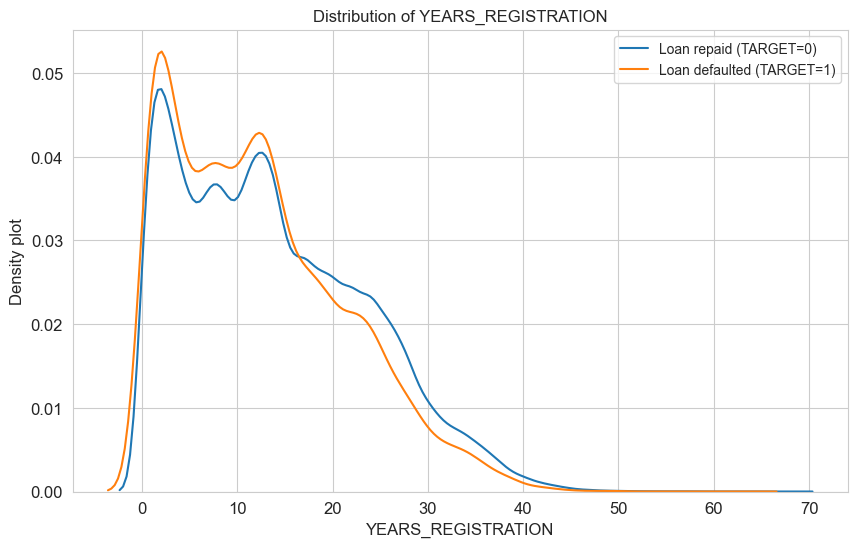

In [42]:
plot_distribution_gen('YEARS_REGISTRATION',None,True)

In [43]:
#create_day_to_year(df_train_OD,['DAYS_ID_PUBLISH'],'YEARS_ID_PUBLISH');

In [ ]:
#plot_distribution_gen('YEARS_ID_PUBLISH',None,True)

In [45]:
# Create INCOME_BAND to group individuals per income range

def create_income_band(df):
    df.loc[(df.AMT_INCOME_TOTAL < 30000),'INCOME_BAND'] = 1
    df.loc[(df.AMT_INCOME_TOTAL >= 30000)&(df.AMT_INCOME_TOTAL < 65000),'INCOME_BAND'] = 2
    df.loc[(df.AMT_INCOME_TOTAL >= 65000)&(df.AMT_INCOME_TOTAL < 95000),'INCOME_BAND'] = 3
    df.loc[(df.AMT_INCOME_TOTAL >= 95000)&(df.AMT_INCOME_TOTAL < 130000),'INCOME_BAND'] = 4
    df.loc[(df.AMT_INCOME_TOTAL >= 130000)&(df.AMT_INCOME_TOTAL < 160000),'INCOME_BAND'] = 5
    df.loc[(df.AMT_INCOME_TOTAL >= 160000)&(df.AMT_INCOME_TOTAL < 190000),'INCOME_BAND'] = 6
    df.loc[(df.AMT_INCOME_TOTAL >= 190000)&(df.AMT_INCOME_TOTAL < 220000),'INCOME_BAND'] = 7
    df.loc[(df.AMT_INCOME_TOTAL >= 220000)&(df.AMT_INCOME_TOTAL < 275000),'INCOME_BAND'] = 8
    df.loc[(df.AMT_INCOME_TOTAL >= 275000)&(df.AMT_INCOME_TOTAL < 325000),'INCOME_BAND'] = 9
    df.loc[(df.AMT_INCOME_TOTAL >= 325000),'INCOME_BAND'] = 10
    return df

In [46]:
create_income_band(df_train_OD);

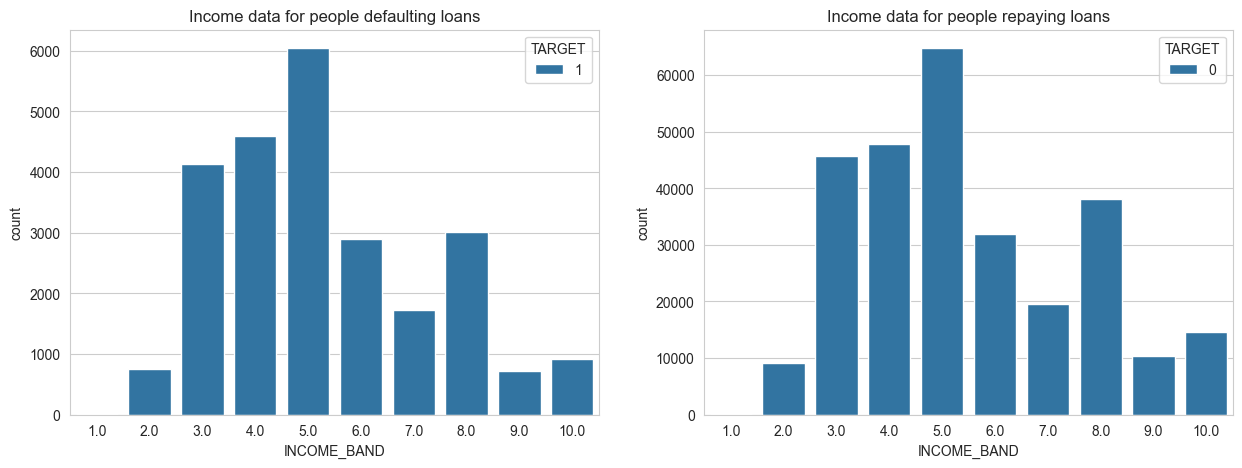

In [47]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot(data=df_train_OD[df_train_OD.TARGET==1],x='INCOME_BAND',hue='TARGET').set_title('Income data for people defaulting loans')
plt.subplot(122)
sns.countplot(data=df_train_OD[df_train_OD.TARGET==0],x='INCOME_BAND',hue='TARGET').set_title('Income data for people repaying loans')
df_train_OD.drop(columns=['INCOME_BAND'],inplace=True);

In [48]:
application_bureau_train = df_train_OD.merge(bureau_OD, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [49]:
print("The resulting dataframe `application_bureau_train` has ",application_bureau_train.shape[0]," rows and ", 
      application_bureau_train.shape[1]," columns.")

The resulting dataframe `application_bureau_train` has  1465325  rows and  138  columns.


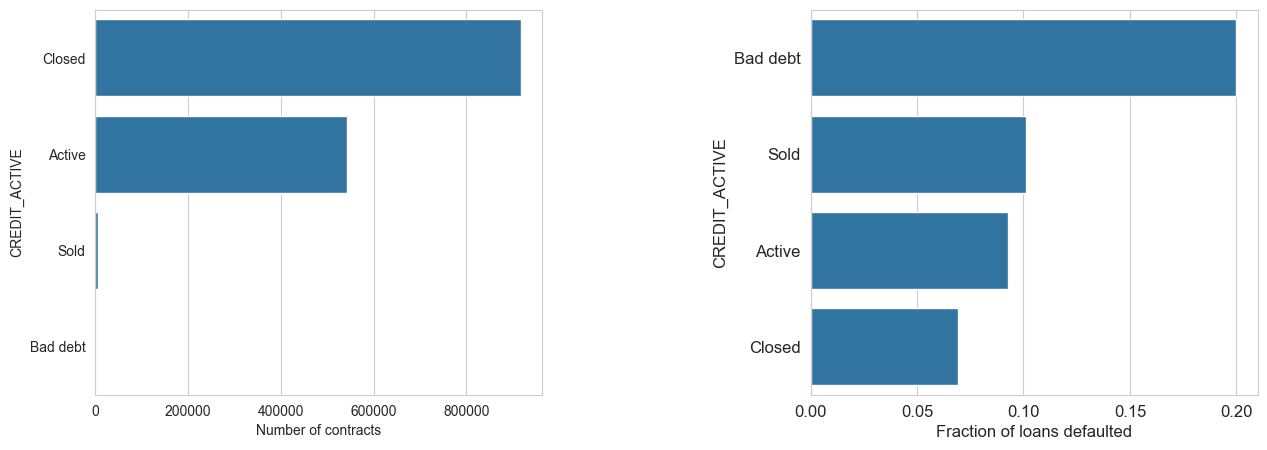

In [50]:
plot_bar_gen('CREDIT_ACTIVE',application_bureau_train)

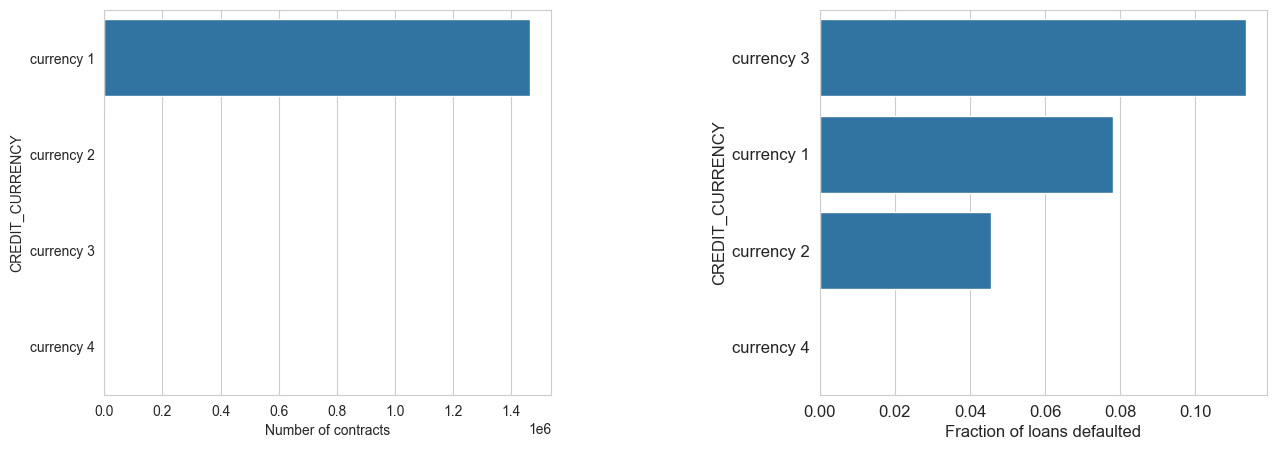

In [51]:
plot_bar_gen('CREDIT_CURRENCY',application_bureau_train)

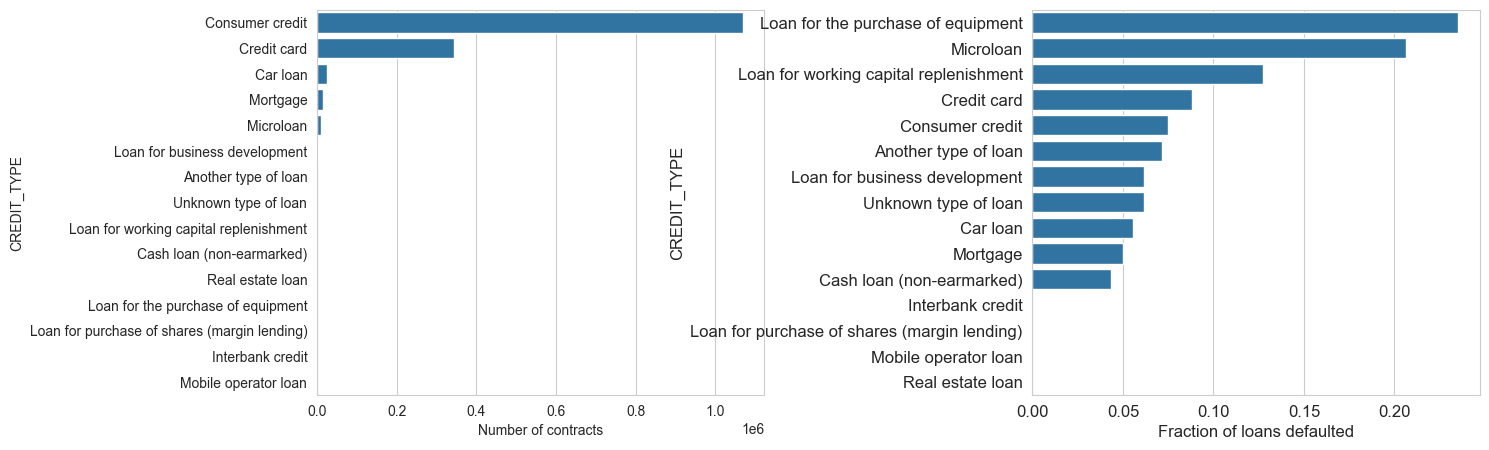

In [52]:
plot_bar_gen('CREDIT_TYPE',application_bureau_train)

In [53]:
application_prev_train = df_train_OD.merge(previous_application_OD, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [54]:
print("The resulting dataframe `application_prev_train` has ",application_prev_train.shape[0]," rows and ", 
      application_prev_train.shape[1]," columns.")

The resulting dataframe `application_prev_train` has  1413701  rows and  158  columns.


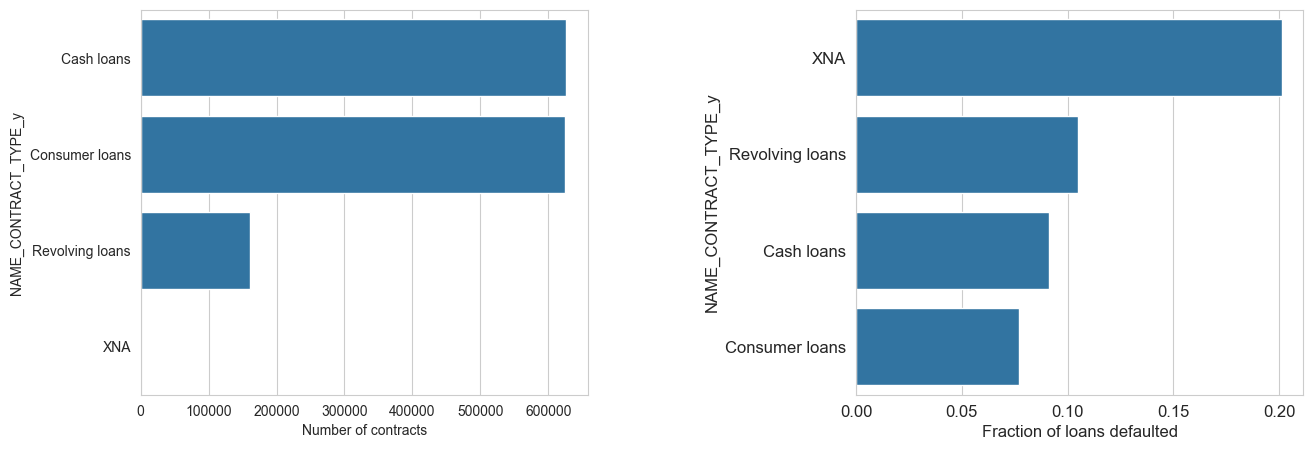

In [55]:
plot_bar_gen('NAME_CONTRACT_TYPE_y',application_prev_train)

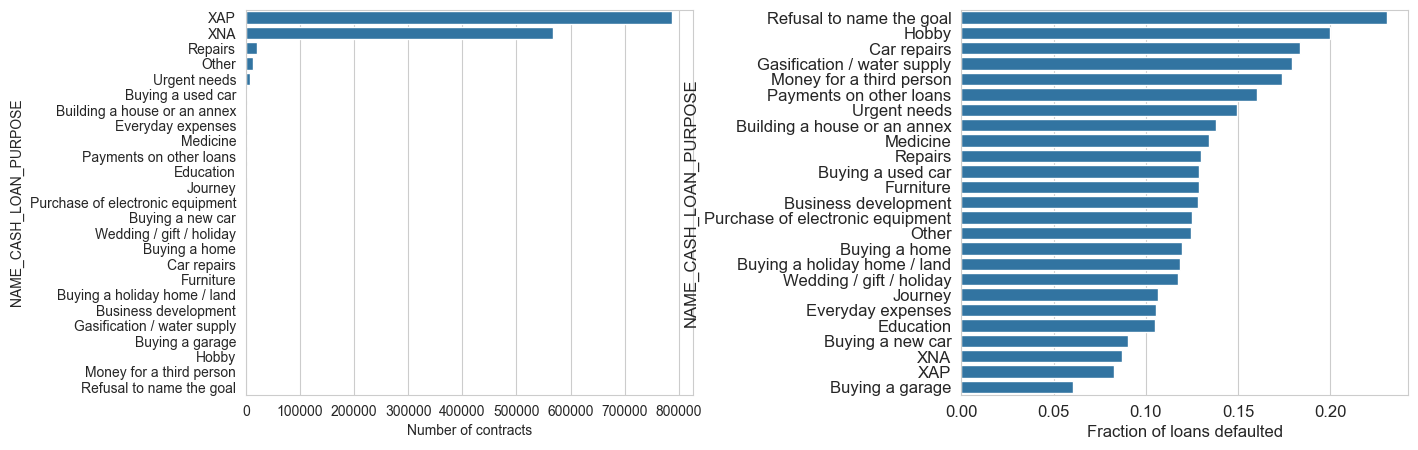

In [56]:
plot_bar_gen('NAME_CASH_LOAN_PURPOSE',application_prev_train)

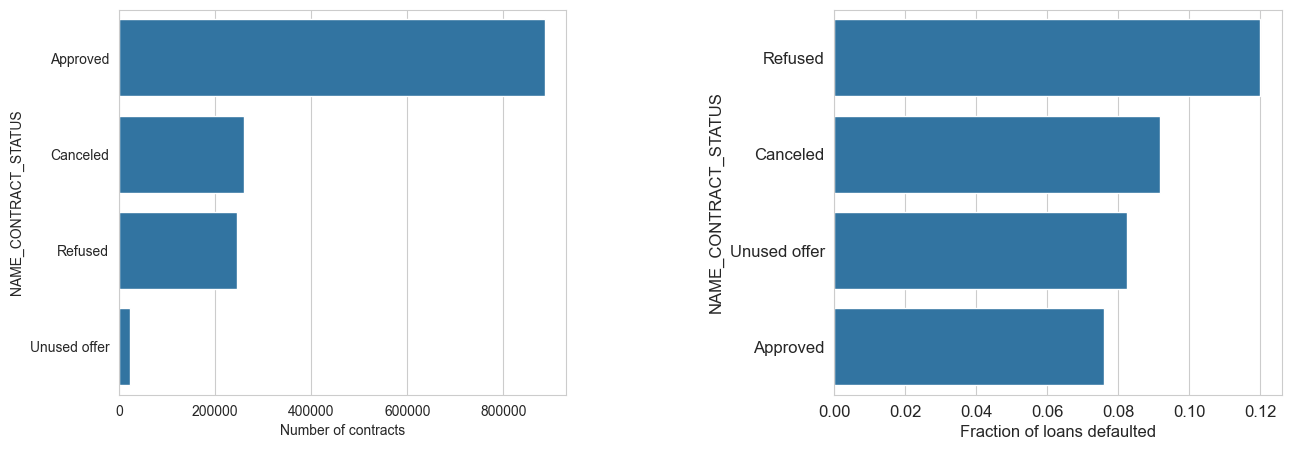

In [57]:
plot_bar_gen('NAME_CONTRACT_STATUS',application_prev_train)

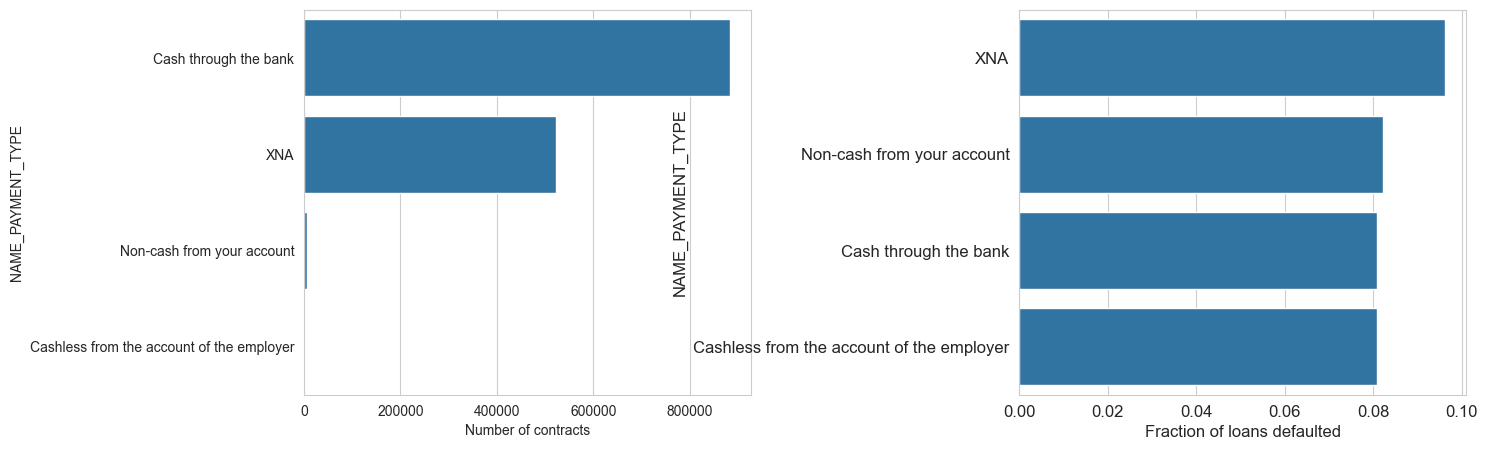

In [58]:
plot_bar_gen('NAME_PAYMENT_TYPE',application_prev_train)


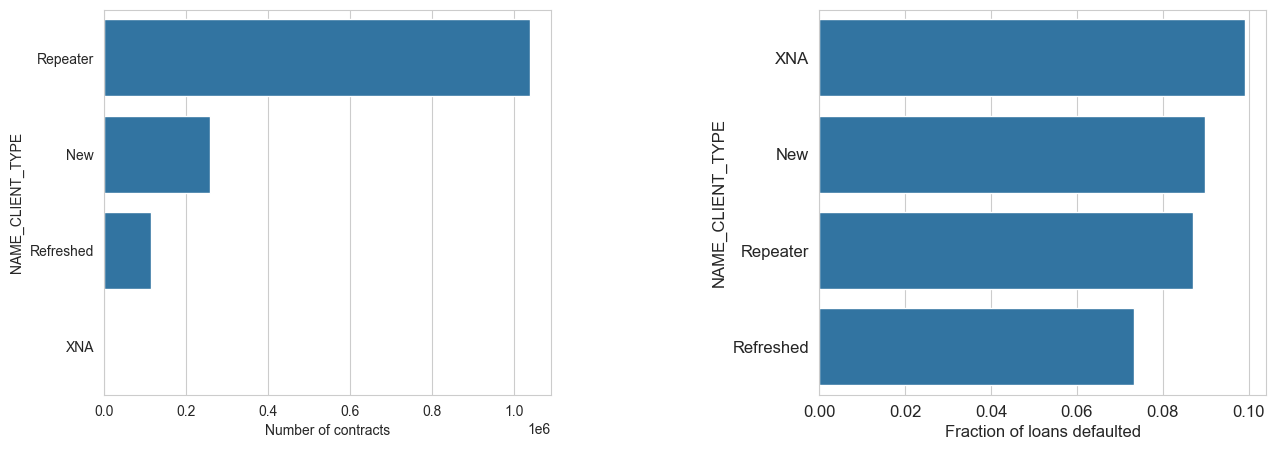

In [59]:
plot_bar_gen('NAME_CLIENT_TYPE',application_prev_train)

Feature Engineering 

In [60]:
import gc

FE (Replacing outliers, imputing, One-hot encoding, Rescaling data)

In [61]:
def replace_day_outliers(df):
    for col in df.columns:
        if "DAYS" in col:
            df[col] = df[col].replace({365243: np.nan})

    return df

Replace all the day outliers

In [62]:
df_train_new = replace_day_outliers(df_train_OD)
bureau_new = replace_day_outliers(bureau_OD)              
bureau_balance_new  = replace_day_outliers(bureau_balance_OD)      
credit_card_balance_new  = replace_day_outliers(credit_card_balance_OD) 
installments_payments_new = replace_day_outliers(installments_payments_OD)
pos_cash_balance_new = replace_day_outliers(pos_cash_balance_OD)   
previous_application_new  = replace_day_outliers(previous_application_OD)

new set path for the optimized data after the EDA for model traing 

In [63]:
""""df_train_new = pd.read_csv("df_train_optimized.csv")
bureau_new = pd.read_csv("bureau_optimized.csv")
bureau_balance_new = pd.read_csv("bureau_balance_optimized.csv")
credit_card_balance_new = pd.read_csv("credit_card_balance_optimized.csv")
installments_payments_new = pd.read_csv("installments_payments_optimized.csv")
pos_cash_balance_new = pd.read_csv("pos_cash_balance_optimized.csv")
previous_application_new = pd.read_csv("previous_application_optimized.csv")"""

'"df_train_new = pd.read_csv("df_train_optimized.csv")\nbureau_new = pd.read_csv("bureau_optimized.csv")\nbureau_balance_new = pd.read_csv("bureau_balance_optimized.csv")\ncredit_card_balance_new = pd.read_csv("credit_card_balance_optimized.csv")\ninstallments_payments_new = pd.read_csv("installments_payments_optimized.csv")\npos_cash_balance_new = pd.read_csv("pos_cash_balance_optimized.csv")\nprevious_application_new = pd.read_csv("previous_application_optimized.csv")'

Create a function to remove columns which have missing values grater than 60%

In [64]:
def remove_missing_col(df):
    miss_data = pd.DataFrame((df.issnumm().sum())*100/df.shape[0])
    miss_data_col = miss_data[miss_data[0]>60].index
    data_new = df[[i for i in df.columns if i not in miss_data_col]]
    return data_new

In [65]:
from sklearn.base import TransformerMixin
import sklearn.externals 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,roc_auc_score,classification_report,roc_curve,auc, f1_score
import pandas as pd


In [66]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        def fit(self, X, y=None):
            self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
            
            return self
        
        def transform(self, X, y=None):
            return X.fillna(self.fill)

In [67]:
base_case_train = pd.get_dummies(df_train_new)

In [68]:
skid_temp = df_train_new['SK_ID_CURR']
train = base_case_train.drop(columns = ['SK_ID_CURR'])
    
# Feature names
features = list(train.columns)

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Median imputation of missing values
imputer = SimpleImputer(strategy='median')
train = imputer.fit_transform(train)

## Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
base_case_train = pd.DataFrame(data=train, columns=features)

print('Data shape: ', base_case_train.shape)

Data shape:  (307511, 245)


In [69]:
base_case_train

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,1.0,0.0,0.207607,0.090287,0.090032,0.077441,0.256336,0.705433,0.098901,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.286846,0.311736,0.132924,0.271605,0.045035,0.959566,0.098901,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.049128,0.022472,0.020025,0.023569,0.134884,0.648326,0.285714,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.128368,0.066837,0.109477,0.063973,0.107049,0.661387,0.098901,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.112520,0.116854,0.078975,0.117845,0.392882,0.519522,0.098901,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.0,0.0,0.154781,0.052360,0.101176,0.046016,0.446891,0.724607,0.098901,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
307507,0.0,0.0,0.054411,0.056067,0.040505,0.046016,0.344412,0.431708,0.098901,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
307508,0.0,0.0,0.149498,0.157969,0.110618,0.135802,0.065226,0.284424,0.098901,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
307509,1.0,0.0,0.170629,0.081175,0.072499,0.069585,0.069575,0.870641,0.098901,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [70]:
base_case_train['SK_ID_CURR'] = skid_temp

print('Data shape: ', base_case_train.shape)

Data shape:  (307511, 246)


In [71]:
train,test = train_test_split(base_case_train,test_size=.25,random_state = 123)

#separating dependent and independent variables
train_X = train[[i for i in train.columns if i not in ['SK_ID_CURR'] + [ 'TARGET']]]
train_Y = train[["TARGET"]]

test_X  = test[[i for i in test.columns if i not in ['SK_ID_CURR'] + [ 'TARGET']]]
test_Y  = test[["TARGET"]]

In [72]:
def model_base(algorithm,dtrain_X,dtrain_Y,dtest_X,dtest_Y,cols=None):
    
    # Extract feature names
    feature_names = list(dtrain_X.columns)
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    algorithm.fit(dtrain_X[cols],dtrain_Y)
    predictions = algorithm.predict(dtest_X[cols])
    prediction_probabilities = algorithm.predict_proba(dtest_X[cols])[:,1]
    
    # Record the feature importances
    feature_importance_values= algorithm.coef_[0]
    feature_importance_values = np.absolute(feature_importance_values)
#     # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    print (algorithm)
    print ("Accuracy score : ", accuracy_score(predictions,dtest_Y))
    print ("classification report :\n",classification_report(predictions,dtest_Y))
    fpr , tpr , thresholds   = roc_curve(dtest_Y,prediction_probabilities)
    
    fig = plt.figure(figsize=(10,8))
    ax  = fig.add_subplot(111)
    ax.plot(fpr,tpr,label   = ["Area under curve : ",auc(fpr,tpr)],linewidth=2,linestyle="dotted")
    ax.plot([0,1],[0,1],linewidth=2,linestyle="dashed")
    plt.legend(loc="best")
    plt.title("ROC-CURVE & AREA UNDER CURVE")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
    return feature_importances

c:\Users\Mr.VL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()
Accuracy score :  0.9184682223783137
classification report :
               precision    recall  f1-score   support

         0.0       1.00      0.92      0.96     76749
         1.0       0.01      0.50      0.02       129

    accuracy                           0.92     76878
   macro avg       0.50      0.71      0.49     76878
weighted avg       1.00      0.92      0.96     76878



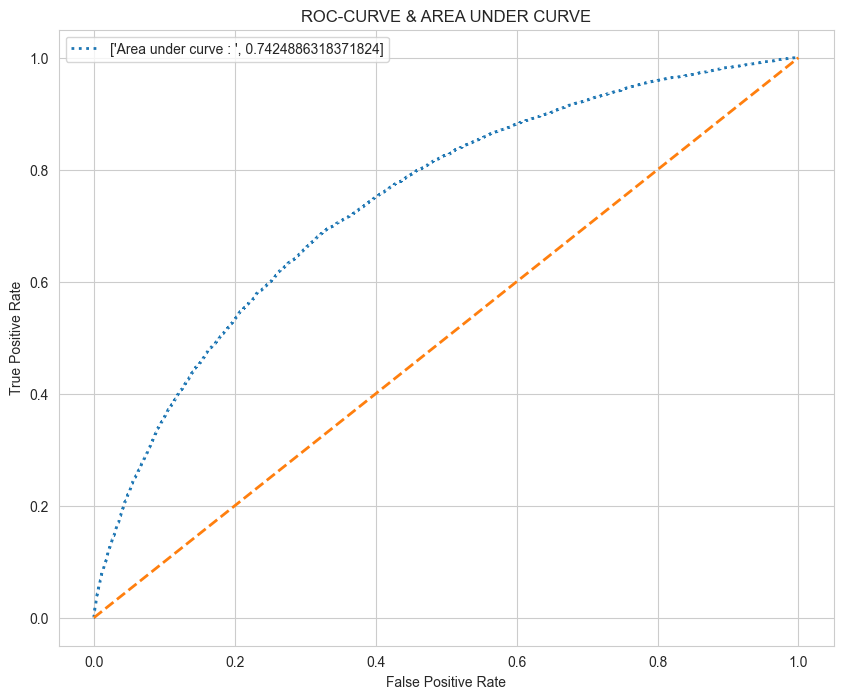

In [73]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()
feature_importances_logit_base = model_base(logit,train_X,train_Y,test_X,test_Y,train_X.columns)

Model 2 : RandomForestClassfier

In [74]:

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score

In [75]:
train_X = train_X.astype('float32')
train_Y = train_Y.astype('int8')
test_X = test_X.astype('float32')
test_Y = test_Y.astype('int8')

In [76]:
smote = SMOTE(random_state=42)
train_X_balanced, train_Y_balanced = smote.fit_resample(train_X, train_Y)

In [77]:
sample_X, _, sample_Y, _ = train_test_split(
    train_X_balanced, train_Y_balanced, 
    train_size=50000, stratify=train_Y_balanced, random_state=42
)

In [85]:
print(train_X_balanced.columns)

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_ID_PUBLISH',
       'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       ...
       'HOUSETYPE_MODE_terraced house', 'WALLSMATERIAL_MODE_Block',
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes'],
      dtype='object', length=244)


In [92]:
rf_model = RandomForestClassifier(random_state=42, class_weight="balanced")

Save model using joblib

In [92]:
joblib.dump(best_rf_model, 'optimized_rf_model.joblib')
loaded_model = joblib.load('optimized_rf_model.joblib')

OR save using Pickle

In [93]:
import pickle

with open('optimized_rf_model.pkl', 'wb') as model_file:
    pickle.dump(best_rf_model, model_file)

# To load the model later
with open('optimized_rf_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)